In [1]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# Helpful statement for debugging, prints the thing entered as x and the output, i.e.,
# debugPrint(1+1) will output '1+1 [int] = 2'
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
    
    
import os
import os, sys
# sys.path.append(os.path.join('~/dev/pytorchSPH/', "lib"))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm.notebook import trange, tqdm
import yaml
%matplotlib notebook
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch
from torch_geometric.nn import radius
from torch_geometric.nn import SplineConv, fps, global_mean_pool, radius_graph, radius
from torch_scatter import scatter

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import tomli
from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

import torch
# import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

In [2]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# TODO:
<!-- 1. Add kinematic visocisty -->
<!-- 2. Backport velocity diffusion to DFSPH code (own module) -->
3. IMPROVE PERFORMANCE
4. Add drag forces
5. delta sph with boundary integrals?!
6. setup dambreak with obstacle
7. setup flow past cylinder
8. add wcsph (müller)
9. add compressible sph
10. setup shockwave scenario for compressible sph

In [3]:
# from src.deltaSPH import deltaSPHSimulation

In [4]:
from src.deltaSPH import deltaSPHSimulation
from src.dfsph import dfsphSimulation

def loadConfig(config):
    with open(config, 'r') as file:
        tomlConfig = file.read()
    parsedConfig = tomli.loads(tomlConfig)
    simulationScheme = 'deltaSPH'
    if 'simulation' in parsedConfig:
        if 'scheme' in parsedConfig['simulation']:
            simulationScheme = parsedConfig['simulation']['scheme']
            
    if simulationScheme == 'deltaSPH' or simulationScheme == 'deltaPlus':
        return parsedConfig, deltaSPHSimulation
    if simulationScheme == 'dfsph':
        return parsedConfig, dfsphSimulation
    

In [8]:
config = 'configs/periodicDomain.toml'

with open(config, 'r') as file:
    tomlConfig = file.read()
parsedConfig = tomli.loads(tomlConfig)

simulationModel = deltaSPHSimulation

sphSimulation = simulationModel(parsedConfig)
sphSimulation.initializeSimulation()

In [9]:
targetNeighbors = 50
minDomain = [-1,-1]
maxDomain = [1,1]

In [14]:
from src.randomParticles import createPotentialFieldTileable
from src.util import evalArea
from src.modules.neighborSearch import radiusCompactHashMap, periodicNeighborSearch
from src.modules.periodicBC import createGhostParticlesKernel


In [165]:

def interpolant(t):
    return t*t*t*(t*(t*6 - 15) + 10)

def generate_perlin_noise_3d(
        shape, res, tileable=(False, False, False),
        interpolant=interpolant, rng = np.random.default_rng(seed=42)
):
    """Generate a 3D numpy array of perlin noise.

    Args:
        shape: The shape of the generated array (tuple of three ints).
            This must be a multiple of res.
        res: The number of periods of noise to generate along each
            axis (tuple of three ints). Note shape must be a multiple
            of res.
        tileable: If the noise should be tileable along each axis
            (tuple of three bools). Defaults to (False, False, False).
        interpolant: The interpolation function, defaults to
            t*t*t*(t*(t*6 - 15) + 10).

    Returns:
        A numpy array of shape shape with the generated noise.

    Raises:
        ValueError: If shape is not a multiple of res.
    """
    delta = (res[0] / shape[0], res[1] / shape[1], res[2] / shape[2])
    d = (shape[0] // res[0], shape[1] // res[1], shape[2] // res[2])
    grid = np.mgrid[0:res[0]:delta[0],0:res[1]:delta[1],0:res[2]:delta[2]]
    grid = np.mgrid[0:res[0]:delta[0],0:res[1]:delta[1],0:res[2]:delta[2]]
    grid = grid.transpose(1, 2, 3, 0) % 1
    # Gradients
    theta = 2*np.pi*np.random.rand(res[0] + 1, res[1] + 1, res[2] + 1)
    phi = 2*np.pi*np.random.rand(res[0] + 1, res[1] + 1, res[2] + 1)
    gradients = np.stack(
        (np.sin(phi)*np.cos(theta), np.sin(phi)*np.sin(theta), np.cos(phi)),
        axis=3
    )
    if tileable[0]:
        gradients[-1,:,:] = gradients[0,:,:]
    if tileable[1]:
        gradients[:,-1,:] = gradients[:,0,:]
    if tileable[2]:
        gradients[:,:,-1] = gradients[:,:,0]
    gradients = gradients.repeat(d[0], 0).repeat(d[1], 1).repeat(d[2], 2)
    g000 = gradients[    :-d[0],    :-d[1],    :-d[2]]
    g100 = gradients[d[0]:     ,    :-d[1],    :-d[2]]
    g010 = gradients[    :-d[0],d[1]:     ,    :-d[2]]
    g110 = gradients[d[0]:     ,d[1]:     ,    :-d[2]]
    g001 = gradients[    :-d[0],    :-d[1],d[2]:     ]
    g101 = gradients[d[0]:     ,    :-d[1],d[2]:     ]
    g011 = gradients[    :-d[0],d[1]:     ,d[2]:     ]
    g111 = gradients[d[0]:     ,d[1]:     ,d[2]:     ]
    # Ramps
    n000 = np.sum(np.stack((grid[:,:,:,0]  , grid[:,:,:,1]  , grid[:,:,:,2]  ), axis=3) * g000, 3)
    n100 = np.sum(np.stack((grid[:,:,:,0]-1, grid[:,:,:,1]  , grid[:,:,:,2]  ), axis=3) * g100, 3)
    n010 = np.sum(np.stack((grid[:,:,:,0]  , grid[:,:,:,1]-1, grid[:,:,:,2]  ), axis=3) * g010, 3)
    n110 = np.sum(np.stack((grid[:,:,:,0]-1, grid[:,:,:,1]-1, grid[:,:,:,2]  ), axis=3) * g110, 3)
    n001 = np.sum(np.stack((grid[:,:,:,0]  , grid[:,:,:,1]  , grid[:,:,:,2]-1), axis=3) * g001, 3)
    n101 = np.sum(np.stack((grid[:,:,:,0]-1, grid[:,:,:,1]  , grid[:,:,:,2]-1), axis=3) * g101, 3)
    n011 = np.sum(np.stack((grid[:,:,:,0]  , grid[:,:,:,1]-1, grid[:,:,:,2]-1), axis=3) * g011, 3)
    n111 = np.sum(np.stack((grid[:,:,:,0]-1, grid[:,:,:,1]-1, grid[:,:,:,2]-1), axis=3) * g111, 3)
    # Interpolation
    t = interpolant(grid)
    n00 = n000*(1-t[:,:,:,0]) + t[:,:,:,0]*n100
    n10 = n010*(1-t[:,:,:,0]) + t[:,:,:,0]*n110
    n01 = n001*(1-t[:,:,:,0]) + t[:,:,:,0]*n101
    n11 = n011*(1-t[:,:,:,0]) + t[:,:,:,0]*n111
    n0 = (1-t[:,:,:,1])*n00 + t[:,:,:,1]*n10
    n1 = (1-t[:,:,:,1])*n01 + t[:,:,:,1]*n11
    return ((1-t[:,:,:,2])*n0 + t[:,:,:,2]*n1)


def generate_fractal_noise_3d(
        shape, res, octaves=1, persistence=0.5, lacunarity=2,
        tileable=(False, False, False), interpolant=interpolant, seed = 1337
):
    """Generate a 3D numpy array of fractal noise.

    Args:
        shape: The shape of the generated array (tuple of three ints).
            This must be a multiple of lacunarity**(octaves-1)*res.
        res: The number of periods of noise to generate along each
            axis (tuple of three ints). Note shape must be a multiple of
            (lacunarity**(octaves-1)*res).
        octaves: The number of octaves in the noise. Defaults to 1.
        persistence: The scaling factor between two octaves.
        lacunarity: The frequency factor between two octaves.
        tileable: If the noise should be tileable along each axis
            (tuple of three bools). Defaults to (False, False, False).
        interpolant: The, interpolation function, defaults to
            t*t*t*(t*(t*6 - 15) + 10).

    Returns:
        A numpy array of fractal noise and of shape shape generated by
        combining several octaves of perlin noise.

    Raises:
        ValueError: If shape is not a multiple of
            (lacunarity**(octaves-1)*res).
    """
    rng = np.random.default_rng(seed=seed)
    noise = np.zeros(shape)
    frequency = 1
    amplitude = 1
    for _ in range(octaves):
        noise += amplitude * generate_perlin_noise_3d(
            shape,
            (frequency*res[0], frequency*res[1], frequency*res[2]),
            tileable,
            interpolant, rng
        )
        frequency *= lacunarity
        amplitude *= persistence
    return noise

def createNoiseFunctionPeriodic(n = 256, res = 2, octaves = 2, lacunarity = 2, persistance = 0.5, seed = 1336):
    noise = generate_fractal_noise_3d(shape = (n, n, n), res = (res,res, res), octaves = octaves, persistence = persistance, lacunarity = lacunarity, tileable = (False, False, False), seed = seed)

    x = np.linspace(-1,1,n)
    y = np.linspace(-1,1,n)
    z = np.linspace(-1,1,n)
    xx, yy, zz = np.meshgrid(x,y,z, indexing='ij', sparse = True)
    fDense = interpolate.RegularGridInterpolator((x, y, z), noise, bounds_error = False, fill_value = None, method = 'linear')

    u = np.linspace(0, 2 * np.pi, n)
    v = np.linspace(0, 2 * np.pi, n)
    uu, vv = np.meshgrid(u, v)

    r1 = 0.5
    r2 = 0.25
    xt = (r1 + r2 * np.cos(vv)) * np.cos(uu)
    yt = (r1 + r2 * np.cos(vv)) * np.sin(uu)
    zt = r2 * np.sin(vv)
    sampled = fDense(np.stack((xt, yt,zt),axis = 2))
    
    return sampled, noise

def createPotentialFieldPeriodic(n = 256, res = 4, octaves = 2, lacunarity = 2, persistance = 0.5, seed = 1336):
    sampled, noise = createNoiseFunctionPeriodic(n = n, res = res, octaves = octaves, lacunarity = lacunarity, persistance = persistance, seed = seed)
#     noise = Octave(n, octaves = octaves, lacunarity = lacunarity, persistance = persistance, seed = seed)

#     noise[:,0] = noise[:,1] - noise[:,2] + noise[:,1]
#     noise[0,:] = noise[1,:] - noise[2,:] + noise[1,:]

#     noise = noise[:n,:n] / 255
    x = np.linspace(-1,1,n)
    y = np.linspace(-1,1,n)
    xx, yy = np.meshgrid(x,y)

#     f = interpolate.RegularGridInterpolator((x, y), noise, bounds_error = False, fill_value = None, method = 'linear')
    
    return xx,yy,sampled

In [173]:
n = 32
res = 2
octaves = 2
persistance = 0.25
lacunarity = 2
seed = 1336

noise = generate_fractal_noise_3d(shape = (n, n, n), res = (res,res, res), octaves = octaves, persistence = persistance, lacunarity = lacunarity, tileable = (False, False, False), seed = seed)

x = np.linspace(-1,1,n)
y = np.linspace(-1,1,n)
z = np.linspace(-1,1,n)
xx, yy, zz = np.meshgrid(x,y,z, indexing='ij', sparse = True)
fDense = interpolate.RegularGridInterpolator((x, y, z), noise, bounds_error = False, fill_value = None, method = 'linear')

u = np.linspace(0, 2 * np.pi, n)
v = np.linspace(0, 2 * np.pi, n)
uu, vv = np.meshgrid(u, v)


<IPython.core.display.Javascript object>


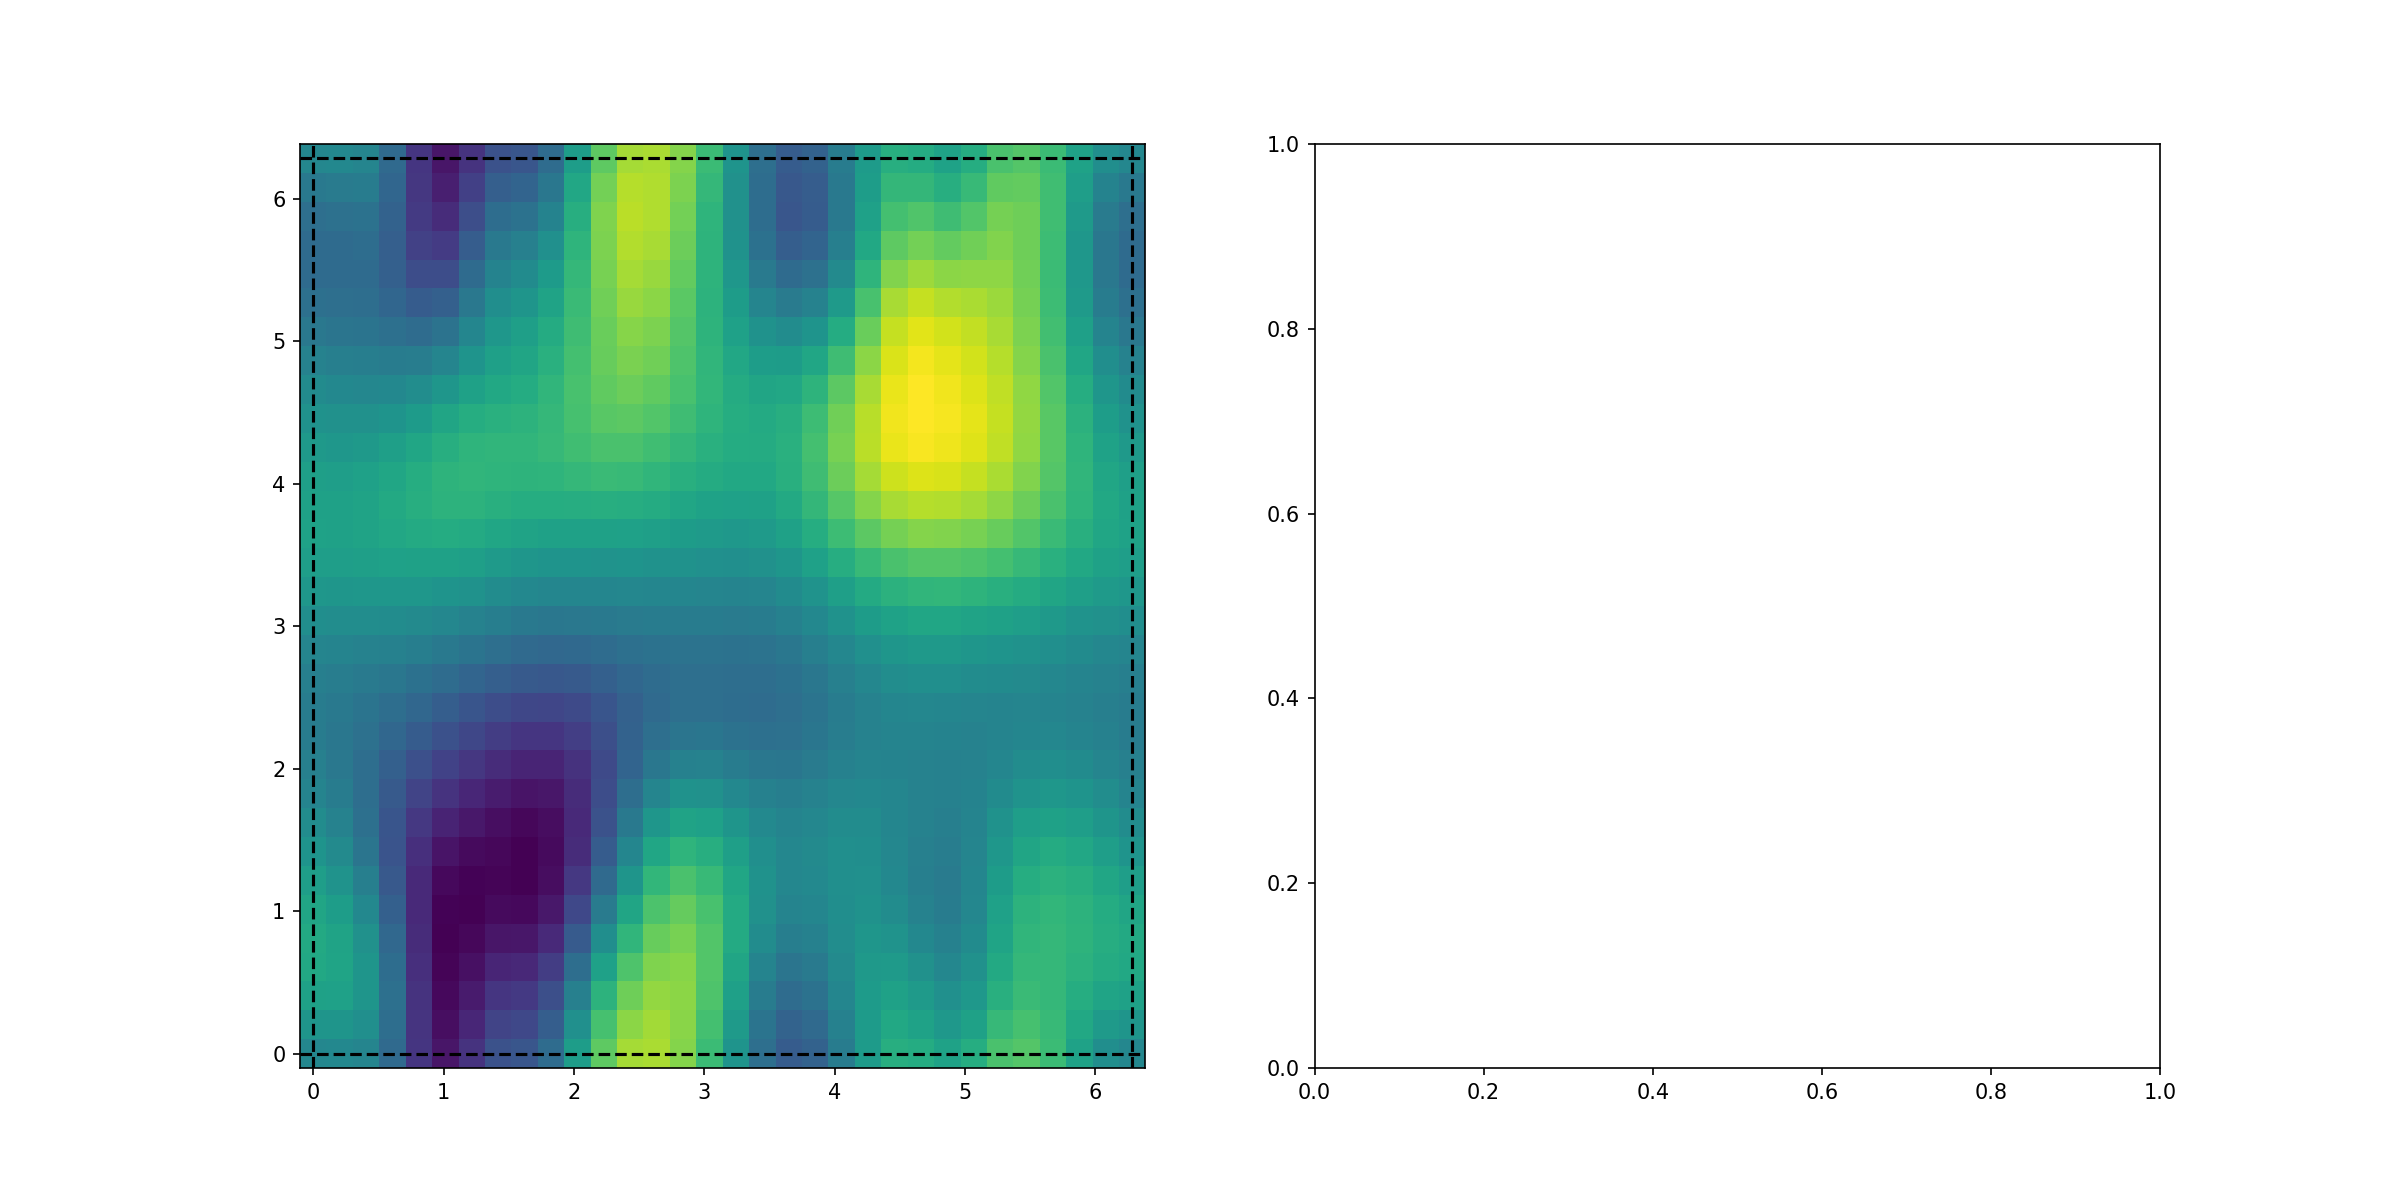

In [174]:
r1 = 0.5
r2 = 0.25
xt = (r1 + r2 * np.cos(vv)) * np.cos(uu)
yt = (r1 + r2 * np.cos(vv)) * np.sin(uu)
zt = r2 * np.sin(vv)
sampled = fDense(np.stack((xt, yt,zt),axis = 2))

fig, axis = plt.subplots(1, 2, figsize=(16,8), sharex = False, sharey = False, squeeze = False)
axis[0,0].pcolormesh(uu,vv,sampled)
axis[0,0].axvline(0,ls='--', c = 'black')
axis[0,0].axhline(0,ls='--', c = 'black')
axis[0,0].axvline(2 * np.pi,ls='--', c = 'black')
axis[0,0].axhline(2 * np.pi,ls='--', c = 'black')
# axis[0,0].pcolormesh(uu + 2 *np.pi,vv,sampled)

In [141]:
fDense([0,0,0])

array([-0.03650842])

In [133]:
((r1 + r2 * np.cos(vv)) * np.cos(uu)).shape

(32, 32)

In [178]:
from scipy import interpolate
from src.util import scatter_sum
from src.kernels import *

def generatePeriodicRandomParticles(
    nx, minDomain = [-1,-1], maxDomain = [1,1], targetNeighbors = 20,
    noiseN = 256, noiseResolution = 2, noiseOctaves = 4,
    noiseLacunarity = 2, noisePersistance = 0.25, noiseSeed = 1337
):
    dx = (maxDomain[0] - minDomain[0]) / nx            
    area = dx**2
    area =  minimize(lambda r: evalArea(r[0], dx, torch.float32, 'cpu', targetNeighbors = targetNeighbors), area, method="nelder-mead", bounds =[(area * 1e-5,area *2)], tol = 1e-7).x[0]
    support = np.single(np.sqrt(area / np.pi * targetNeighbors))
    
    
    xx = np.linspace(minDomain[0] + dx / 2, maxDomain[0] - dx / 2, nx)
    yy = np.linspace(minDomain[1] + dx / 2, maxDomain[1] - dx / 2, nx)

    XX, YY = np.meshgrid(xx,yy)
    ptcls = np.stack((XX,YY), axis = 2).flatten().reshape((nx * nx, 2))
    
    xx, yy, noise = createPotentialFieldPeriodic(n = noiseN, res = noiseResolution, \
                    octaves = noiseOctaves, lacunarity = noiseLacunarity, persistance = noisePersistance, \
                        seed = noiseSeed)

# filtered = filterNoise(noise, minDomain, minCenter, boundary = self.config['generative']['boundaryWidth'], nd = np.array(self.config['generative']['nd']), n = self.config['generative']['n'], dh = 1e-2)
    noiseSampler = interpolate.RegularGridInterpolator((np.linspace(minDomain[0],maxDomain[0],noiseN), np.linspace(minDomain[1],maxDomain[1],noiseN)), noise, bounds_error = False, fill_value = None, method = 'linear')


    x = torch.tensor(ptcls).type(torch.float32)
    i, j, fluidDistances, fluidRadialDistances = periodicNeighborSearch(torch.tensor(ptcls).type(torch.float32), minDomain, maxDomain, support, True, True, True)

    rho = scatter_sum(area * kernel(fluidRadialDistances, support), i, dim = 0, dim_size = x.shape[0])

    potential = torch.tensor(noiseSampler((x[:,0].detach().cpu().numpy(), x[:,1].detach().cpu().numpy()))).to(x.device).type(x.dtype)

    gradTerm = (area / rho[j]  *  (potential[j] - potential[i]))[:,None] * kernelGradient(fluidRadialDistances, fluidDistances, support)

    potentialGradient = scatter(gradTerm, i, dim=0, dim_size=x.size(0), reduce="add")

    velocities = torch.zeros_like(potentialGradient)
    velocities[:,0] = potentialGradient[:,1]
    velocities[:,1] = -potentialGradient[:,0]

    gterm = area / rho[j]  * torch.einsum('nd, nd -> n', velocities[j] - velocities[i], kernelGradient(fluidRadialDistances, fluidDistances, support))

    div = scatter(gterm, i, dim=0, dim_size=x.size(0), reduce="add")
    
    return x, dx, area, support, potential, rho, velocities, div

In [179]:

def scatterPlot(fig, axis, ptcls, data):
    sc = axis.scatter(ptcls[:,0], ptcls[:,1], s = 2048 / np.sqrt(ptcls.shape[0]), c = data)
    axis.axis('equal')
    axis.set_xlim(minDomain[0] - 2 * dx, maxDomain[0] + 2 * dx)
    axis.set_ylim(minDomain[1] - 2 * dx, maxDomain[1] + 2 * dx)
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.axvline(minDomain[0], ls = '--', c = 'black')
    axis.axhline(minDomain[1], ls = '--', c = 'black')
    axis.axvline(maxDomain[0], ls = '--', c = 'black')
    axis.axhline(maxDomain[1], ls = '--', c = 'black')

<IPython.core.display.Javascript object>


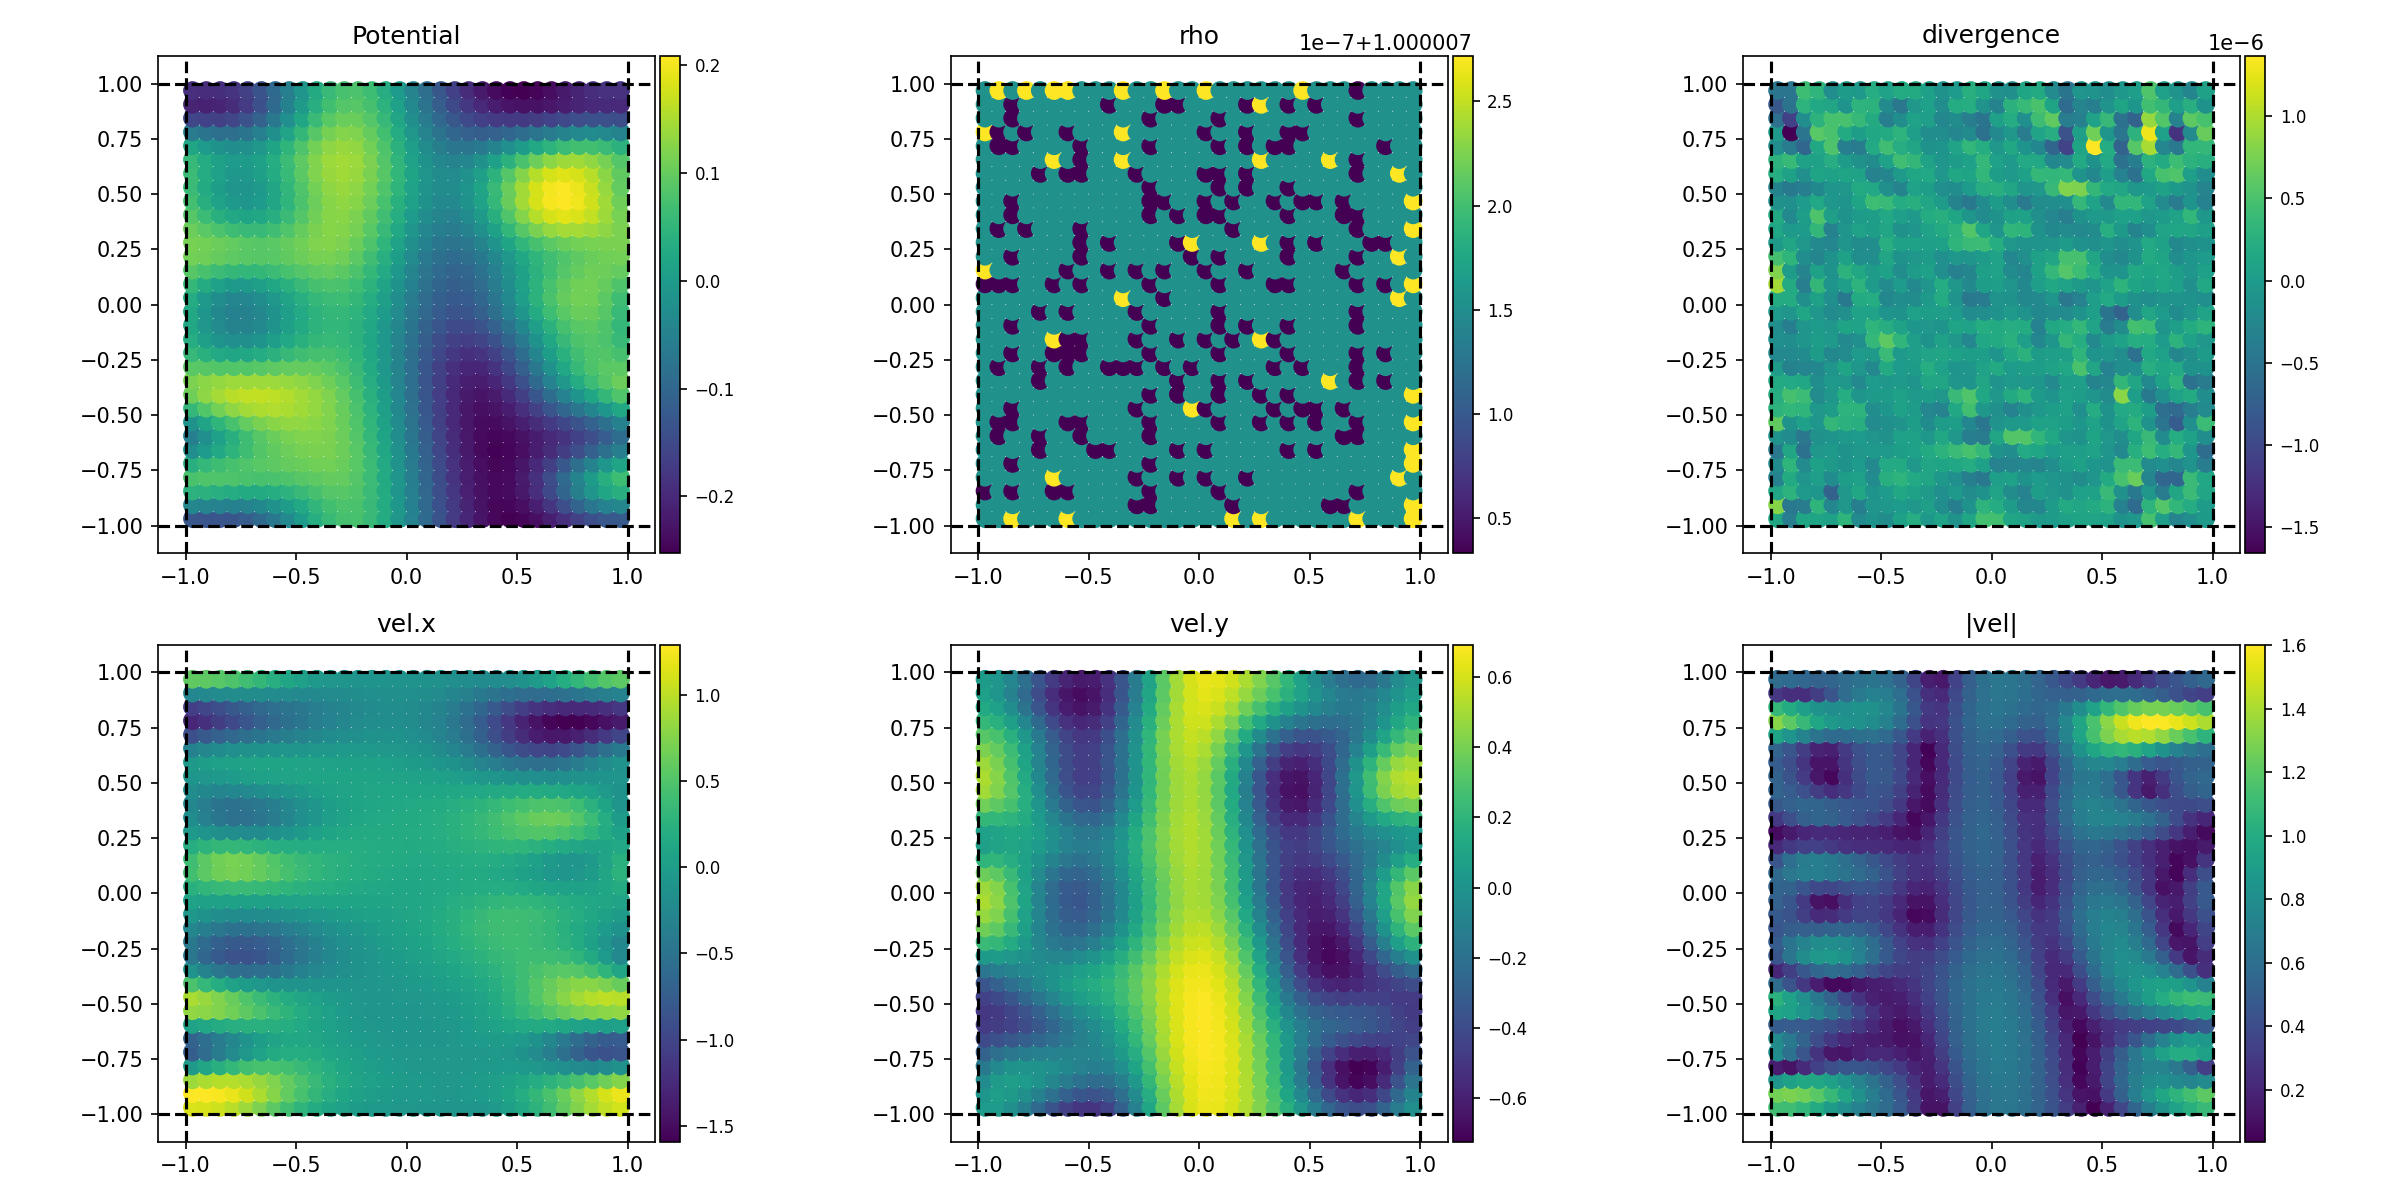

In [180]:
x, dx, area, support, potential, rho, velocities, div = generatePeriodicRandomParticles(32, noiseOctaves = 1, noiseN = 32)

fig, axis = plt.subplots(2, 3, figsize=(16,8), sharex = False, sharey = False, squeeze = False)
axis[0,0].set_title('Potential')
scatterPlot(fig, axis[0,0], x, potential)
axis[0,1].set_title('rho')
scatterPlot(fig,axis[0,1], x, rho)
axis[0,2].set_title('divergence')
scatterPlot(fig,axis[0,2], x, div)
axis[1,0].set_title('vel.x')
scatterPlot(fig,axis[1,0], x, velocities[:,0])
axis[1,1].set_title('vel.y')
scatterPlot(fig,axis[1,1], x, velocities[:,1])
axis[1,2].set_title('|vel|')
scatterPlot(fig,axis[1,2], x, torch.linalg.norm(velocities, dim = -1))
fig.tight_layout()


<IPython.core.display.Javascript object>


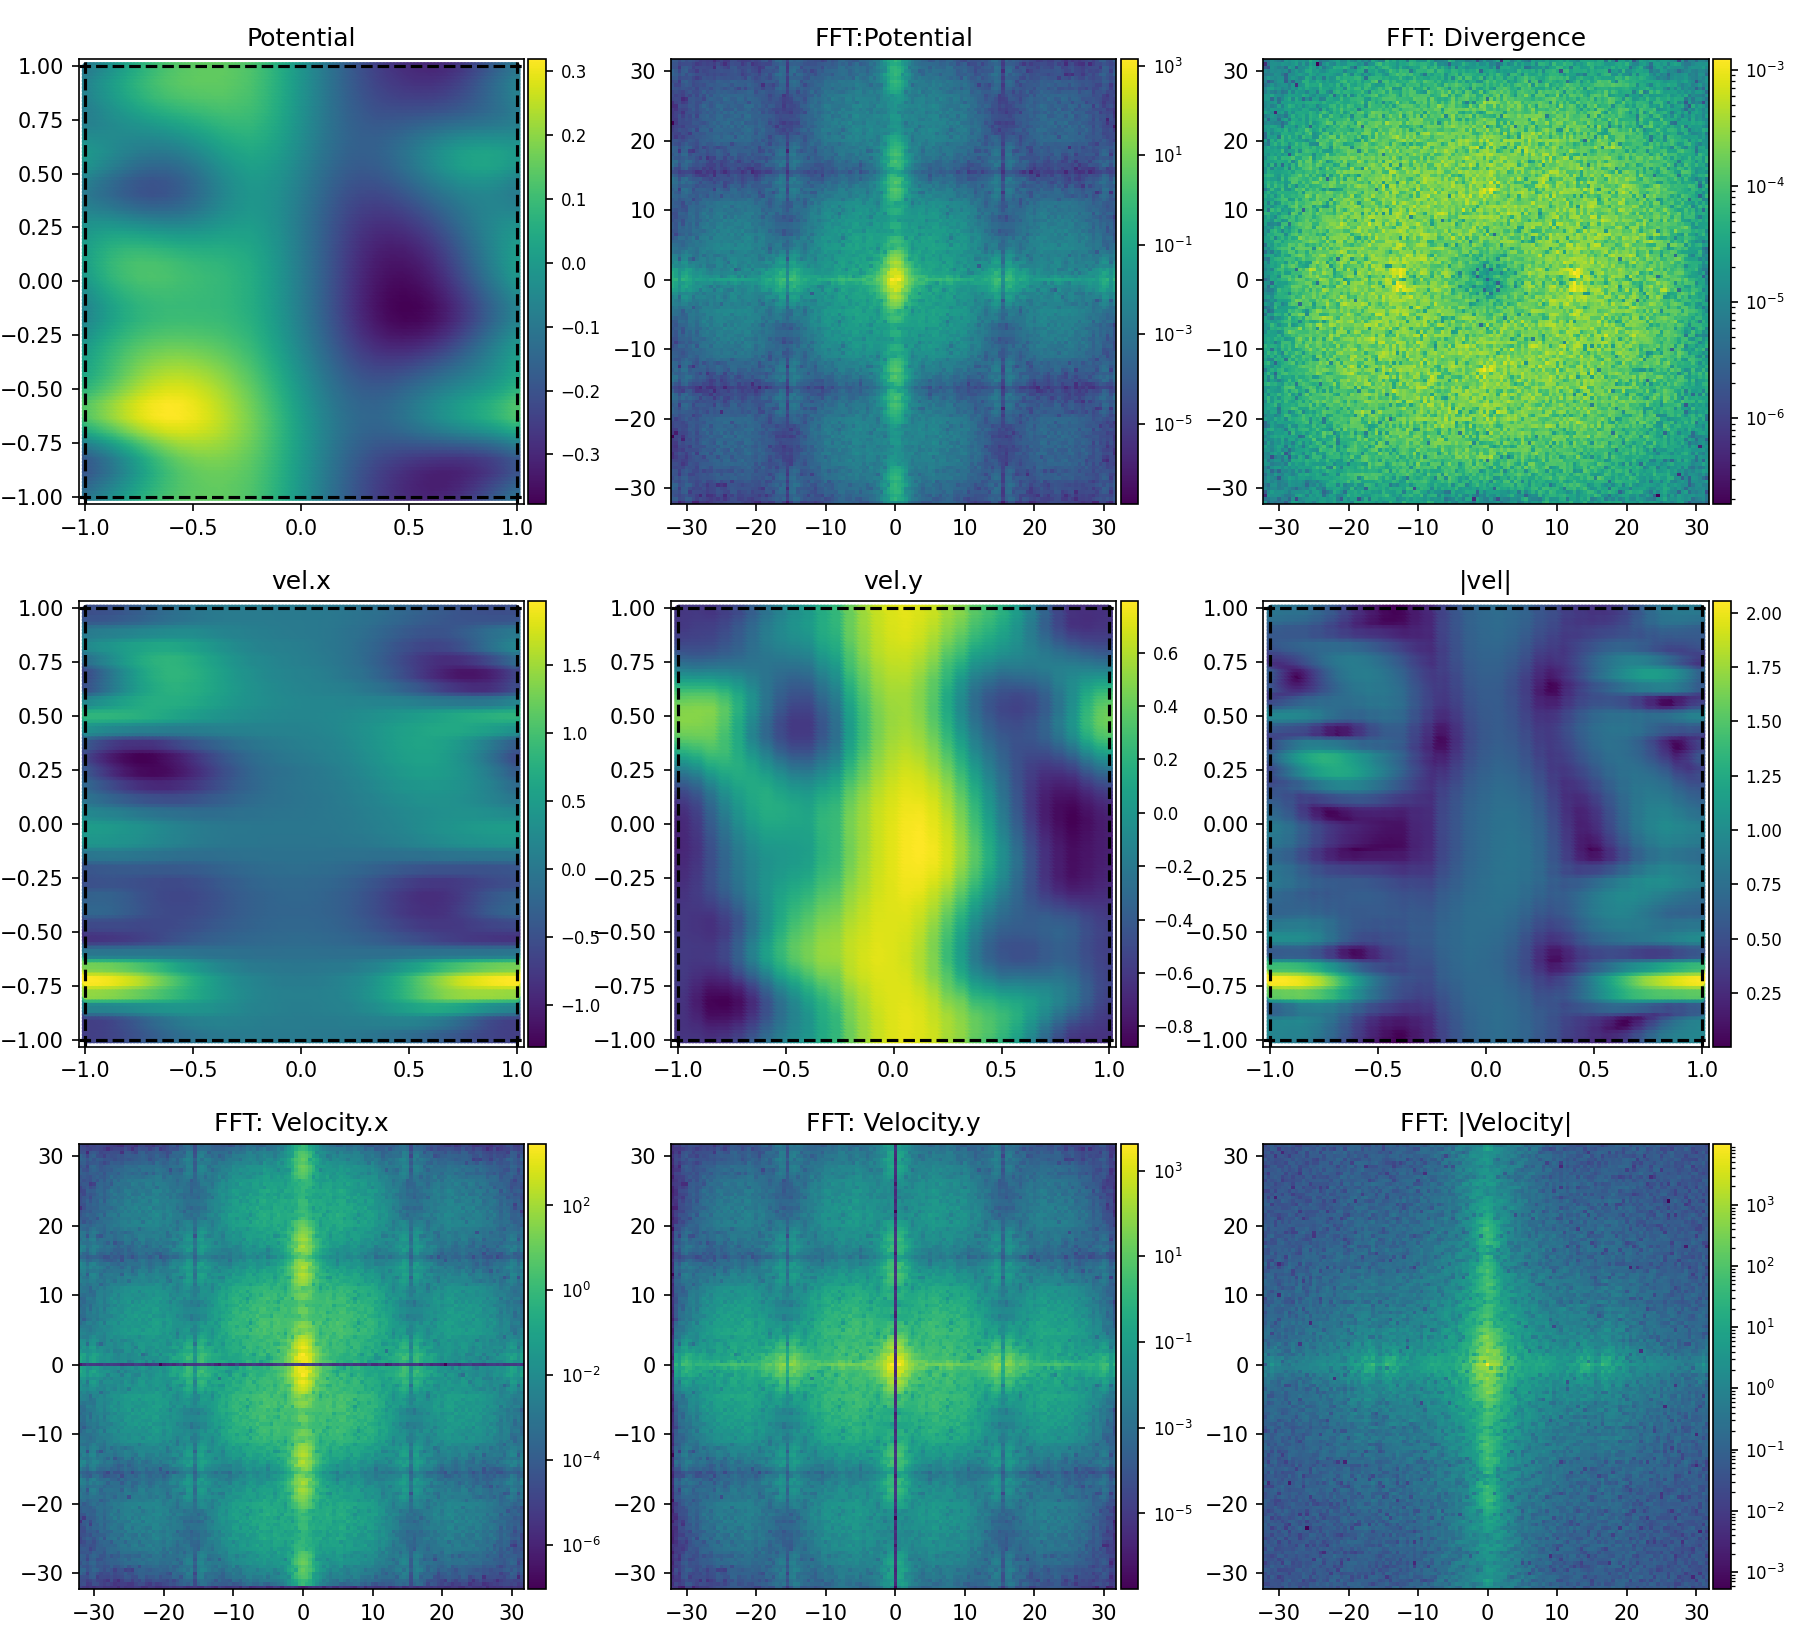

In [181]:

import matplotlib.colors as colors
x, dx, area, support, potential, rho, velocities, div = generatePeriodicRandomParticles(128, noiseOctaves = 1, noiseN = 32)

xx = x.reshape(int(np.sqrt(x.shape[0])),int(np.sqrt(x.shape[0])),2)[:,:,0]
yy = x.reshape(int(np.sqrt(x.shape[0])),int(np.sqrt(x.shape[0])),2)[:,:,1]
vx = velocities.reshape(int(np.sqrt(x.shape[0])),int(np.sqrt(x.shape[0])),2)[:,:,0]
vy = velocities.reshape(int(np.sqrt(x.shape[0])),int(np.sqrt(x.shape[0])),2)[:,:,1]
p = potential.reshape(int(np.sqrt(x.shape[0])),int(np.sqrt(x.shape[0])))
density = rho.reshape(int(np.sqrt(x.shape[0])),int(np.sqrt(x.shape[0])))
divergence = div.reshape(int(np.sqrt(x.shape[0])),int(np.sqrt(x.shape[0])))
v = torch.linalg.norm(velocities, dim = -1).reshape(int(np.sqrt(x.shape[0])),int(np.sqrt(x.shape[0])))


def plotFFT(fig, axis, data,title):
    Z = np.fft.fft2(data)
    Zshift = np.fft.fftshift(np.fft.fft2(data))
    FreqCompRows = np.fft.fftfreq(Z.shape[0],d= 2 / data.shape[0])
    FreqCompCols = np.fft.fftfreq(Z.shape[1],d=2  / data.shape[0])
    FreqCompRows = np.fft.fftshift(FreqCompRows)
    FreqCompCols = np.fft.fftshift(FreqCompCols)
    S,D = np.meshgrid(FreqCompRows, FreqCompCols)
    Zs = np.abs(Zshift)
    im = axis.pcolormesh(S,D,Zs, norm=colors.LogNorm(vmin=Zs.min(), vmax=Zs.max()))
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(im, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    axis.axis('equal')

fig, axis = plt.subplots(3, 3, figsize=(12,11), sharex = False, sharey = False, squeeze = False)
axis[0,0].set_title('Potential')
scatterPlot(fig,axis[0,0], x, potential)
plotFFT(fig, axis[0,1], p, 'FFT:Potential')
# plotFFT(fig, axis[0,1], density, 'Density')
plotFFT(fig, axis[0,2], divergence, 'FFT: Divergence')
axis[1,0].set_title('vel.x')
scatterPlot(fig,axis[1,0], x, velocities[:,0])
axis[1,1].set_title('vel.y')
scatterPlot(fig,axis[1,1], x, velocities[:,1])
axis[1,2].set_title('|vel|')
scatterPlot(fig,axis[1,2], x, torch.linalg.norm(velocities, dim = -1))

plotFFT(fig, axis[2,0], vx, 'FFT: Velocity.x')
plotFFT(fig, axis[2,1], vy, 'FFT: Velocity.y')
plotFFT(fig, axis[2,2], v, 'FFT: |Velocity|')

fig.tight_layout()

(1024, 2)


<IPython.core.display.Javascript object>


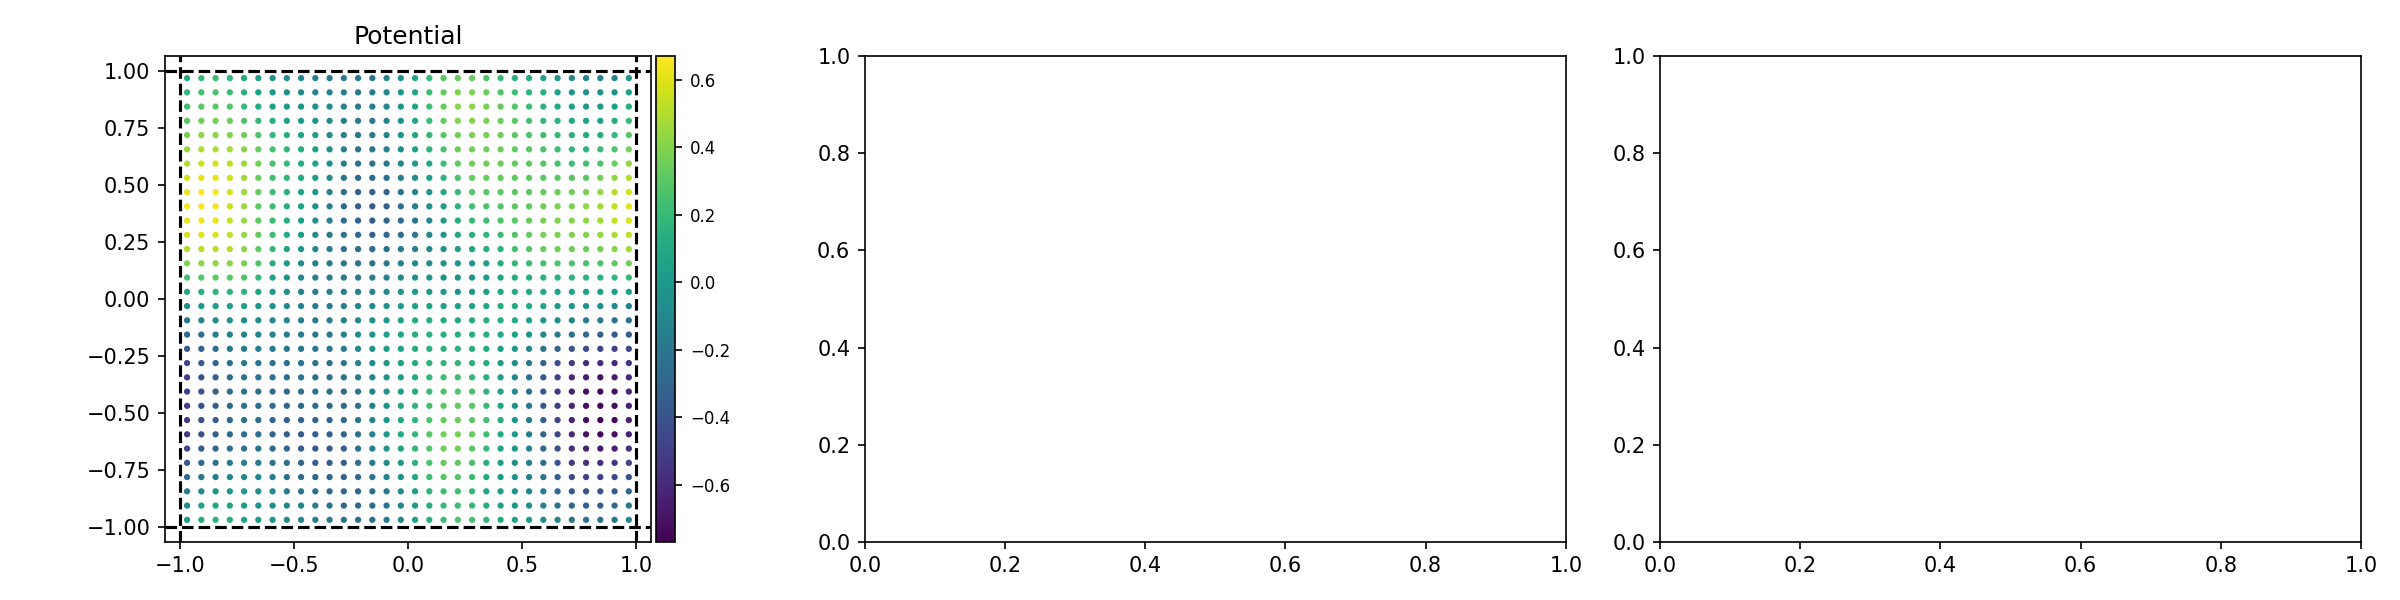

In [11]:


# nx = max(sphSimulation.config['generative']['nb'][0], sphSimulation.config['generative']['nb'][1])
nx = 32
# r = np.sqrt(area/ np.pi)
# area = np.pi * r**2




print(ptcls.shape)


def scatter(fig, axis, ptcls, data):
    sc = axis.scatter(ptcls[:,0], ptcls[:,1], s = 4, c = data)
    axis.axis('equal')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.axvline(minDomain[0], ls = '--', c = 'black')
    axis.axvline(maxDomain[0], ls = '--', c = 'black')
    axis.axhline(minDomain[1], ls = '--', c = 'black')
    axis.axhline(maxDomain[1], ls = '--', c = 'black')
    
# xx, yy, noise = createPotentialField(n = sphSimulation.config['generative']['n'], res = sphSimulation.config['generative']['res'], \
#                     octaves = sphSimulation.config['generative']['octaves'], lacunarity = sphSimulation.config['generative']['lacunarity'], persistance = sphSimulation.config['generative']['persistance'], \
#                         seed = sphSimulation.config['generative']['seed'])
potential = noiseSampler((ptcls[:,0], ptcls[:,1]))

fig, axis = plt.subplots(1, 3, figsize=(16,4), sharex = False, sharey = False, squeeze = False)
scatter(fig, axis[0,0], ptcls, potential)
axis[0,0].set_title('Potential')
# scatter(fig, axis[0,1], ptcls, vel[:,1])
# scatter(fig, axis[0,2], ptcls, np.linalg.norm(vel, axis = 1))
    
fig.tight_layout()

In [12]:

# dx = (maxDomain[0] - minDomain[0]) / nx            

# xx = np.linspace(minDomain[0] + dx / 2, maxDomain[0] - dx / 2, nx)
# print(xx)
# print(xx[1] - xx[0])
# print(dx)
# print((xx[1] - xx[0]) * (nx + 1) + dx)
# print(xx.shape)


In [19]:

# i, j, fluidDistances, fluidRadialDistances = periodicNeighborSearch(torch.tensor(ptcls).type(torch.float32), sphSimulation.config['domain']['min'], sphSimulation.config['domain']['max'], support, True, True, True)

In [41]:
print(potential.dtype)

float64


In [30]:
print(dx)

0.0625


<IPython.core.display.Javascript object>


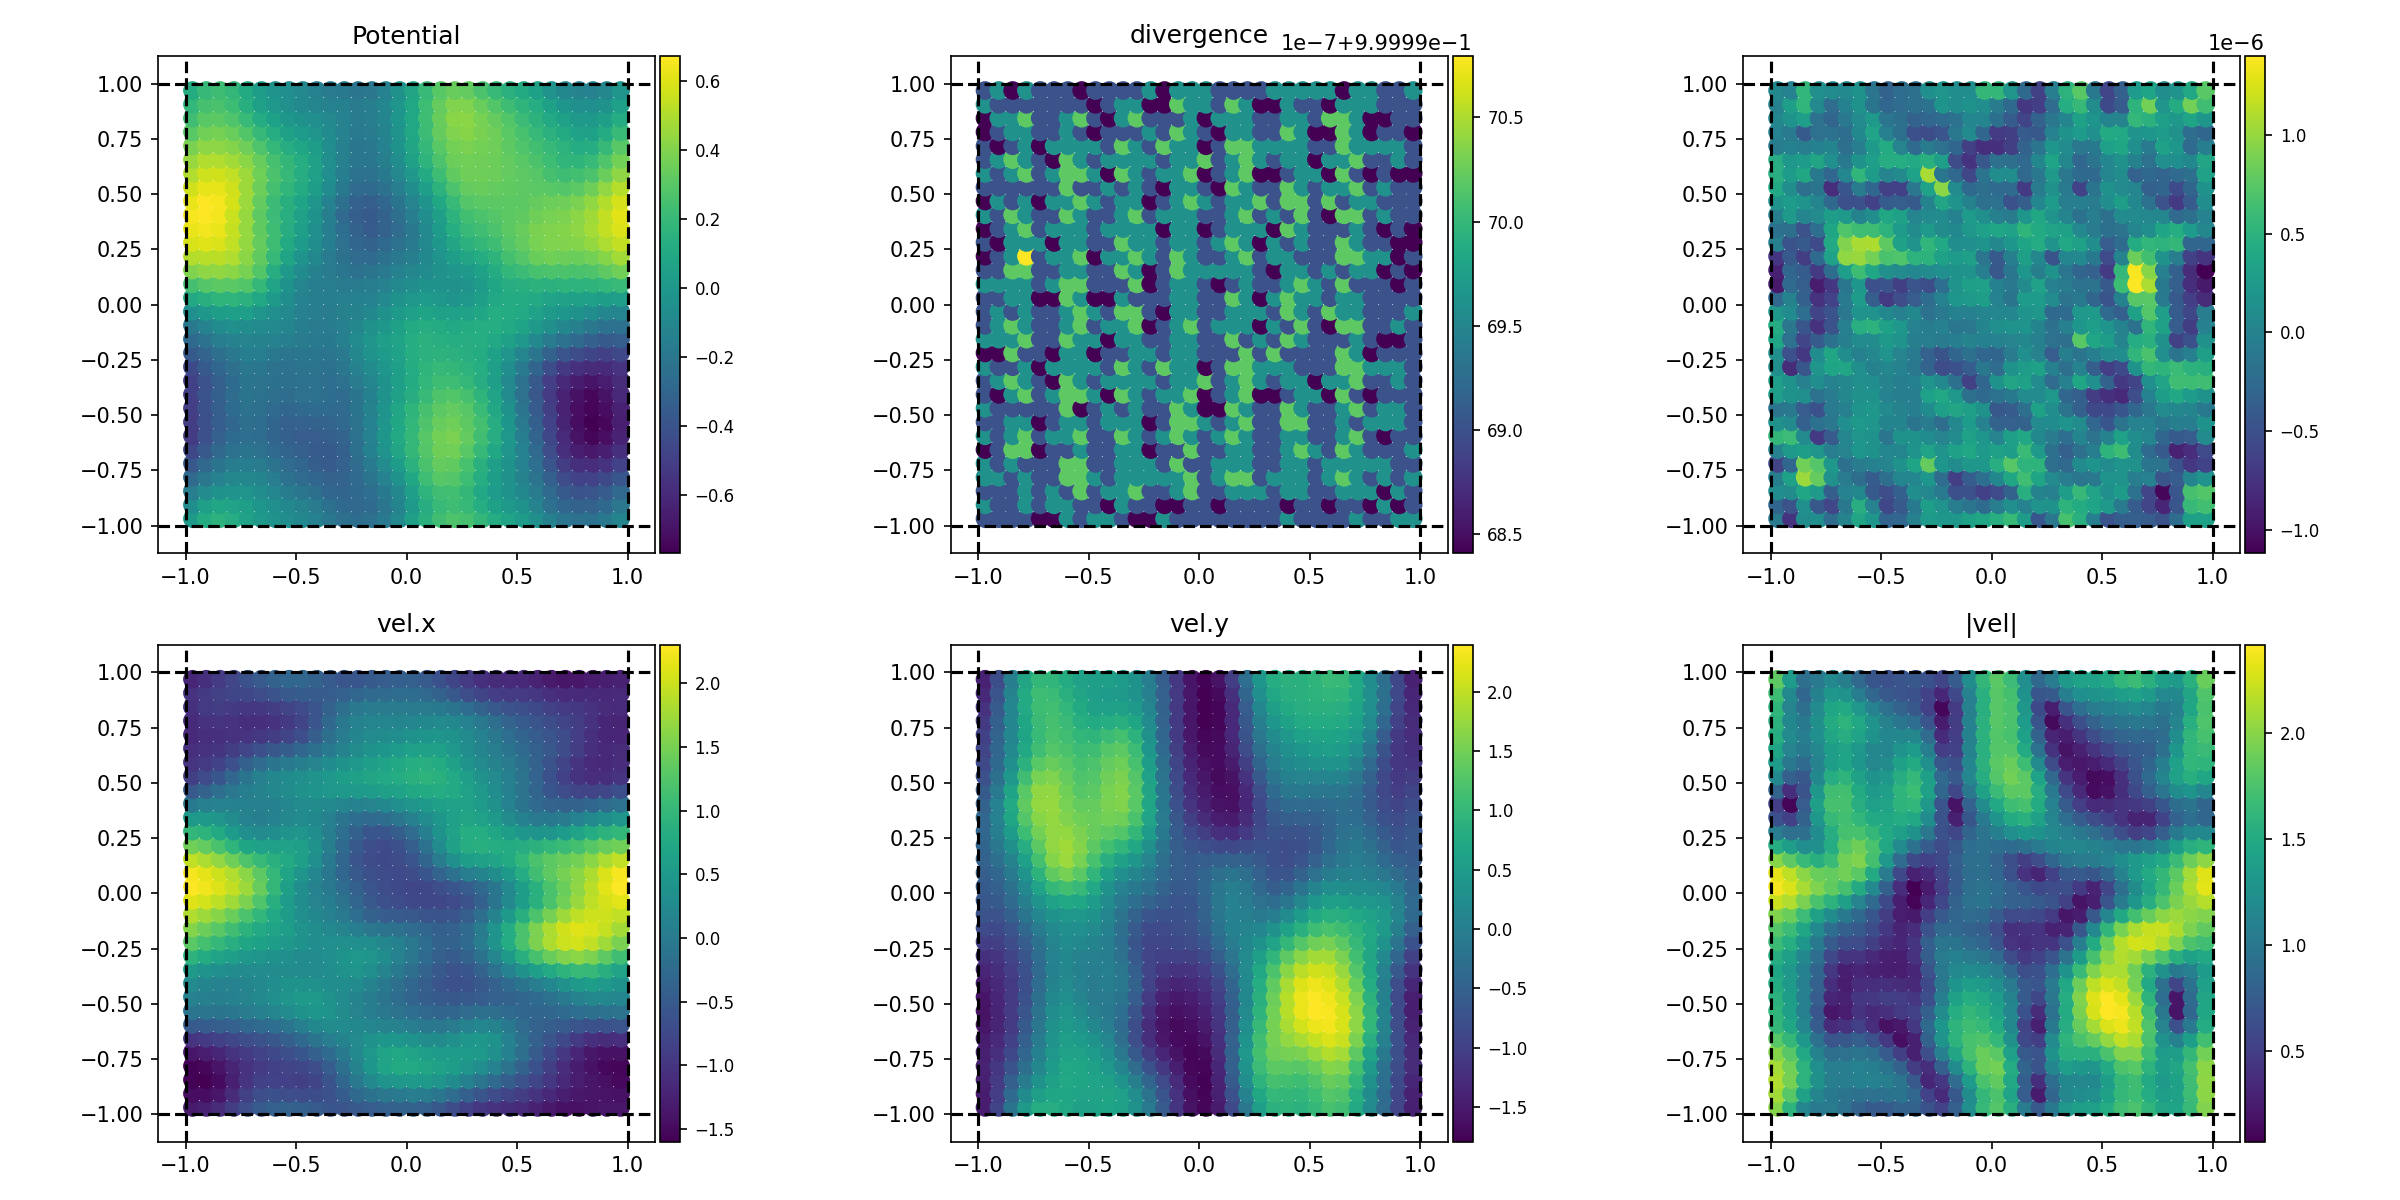

In [46]:
def scatterPlot(fig, axis, ptcls, data):
    sc = axis.scatter(ptcls[:,0], ptcls[:,1], s = 2048 / nx, c = data)
    axis.axis('equal')
    axis.set_xlim(minDomain[0] - 2 * dx, maxDomain[0] + 2 * dx)
    axis.set_ylim(minDomain[1] - 2 * dx, maxDomain[1] + 2 * dx)
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.axvline(minDomain[0], ls = '--', c = 'black')
    axis.axhline(minDomain[1], ls = '--', c = 'black')
    axis.axvline(maxDomain[0], ls = '--', c = 'black')
    axis.axhline(maxDomain[1], ls = '--', c = 'black')
    
fig, axis = plt.subplots(2, 3, figsize=(16,8), sharex = False, sharey = False, squeeze = False)

axis[0,0].set_title('Potential')
scatterPlot(fig, axis[0,0], x, potential)

axis[0,1].set_title('rho')
scatterPlot(fig,axis[0,1], x, rho)

axis[0,1].set_title('divergence')
scatterPlot(fig,axis[0,2], x, div)

axis[1,0].set_title('vel.x')
scatterPlot(fig,axis[1,0], x, velocities[:,0])
axis[1,1].set_title('vel.y')
scatterPlot(fig,axis[1,1], x, velocities[:,1])
axis[1,2].set_title('|vel|')
scatterPlot(fig,axis[1,2], x, torch.linalg.norm(velocities, dim = -1))
# scatter(fig, axis[0,2], ptcls, np.linalg.norm(vel, axis = 1))
    
fig.tight_layout()

<IPython.core.display.Javascript object>


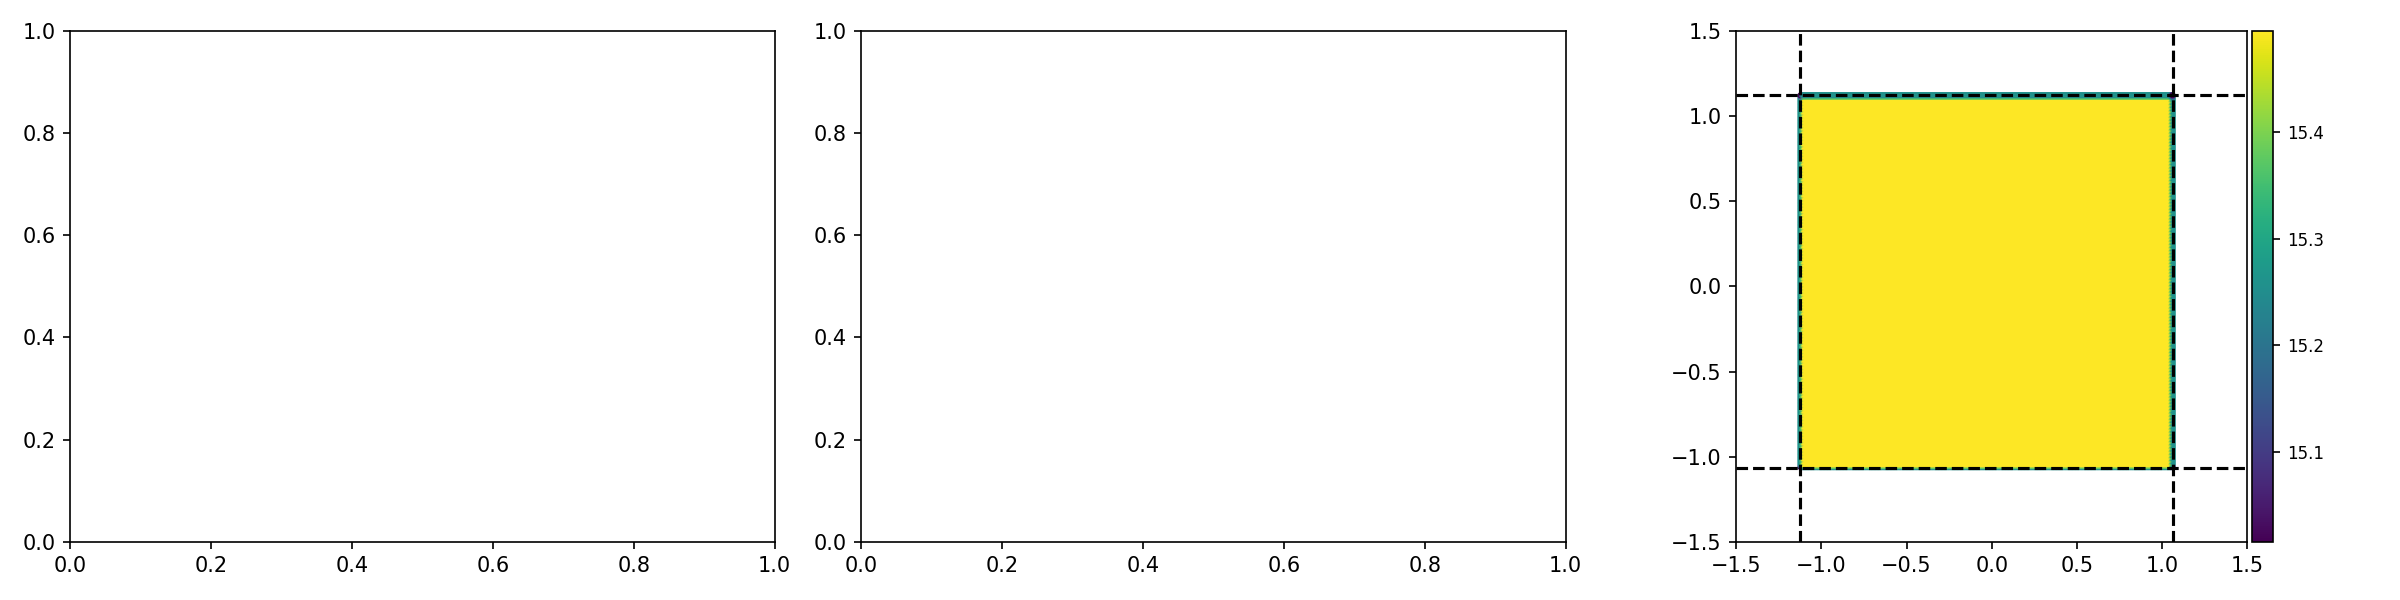

In [100]:
def scatter(fig, axis, ptcls, data):
    sc = axis.scatter(ptcls[:,0], ptcls[:,1], s = 4, c = data)
    axis.axis('equal')
    axis.set_xlim(-1.5, 1.5)
    axis.set_ylim(-1.5, 1.5)
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.axvline(sphSimulation.config['domain']['min'][0], ls = '--', c = 'black')
    axis.axhline(sphSimulation.config['domain']['min'][1], ls = '--', c = 'black')
    axis.axvline(sphSimulation.config['domain']['max'][0], ls = '--', c = 'black')
    axis.axhline(sphSimulation.config['domain']['max'][1], ls = '--', c = 'black')
    
fig, axis = plt.subplots(1, 3, figsize=(16,4), sharex = False, sharey = False, squeeze = False)

# axis[0,0].set_title('Potential')
# scatter(fig, axis[0,0], x, potential)
# ii, ni = torch.unique(i, return_counts = True)
# jj, nj = torch.unique(j, return_counts = True)
# axis[0,1].set_title('ni')
# scatter(fig,axis[0,1], x, ni)
# axis[0,2].set_title('rho')

# rho = scatter_sum(area * kernel(fluidRadialDistances, support), j, dim = 0, dim_size = x.shape[0])
rho = scatter_sum(fluidRadialDistances, i, dim = 0, dim_size = x.shape[0])
scatter(fig,axis[0,2], x, rho)
# scatter(fig, axis[0,2], ptcls, np.linalg.norm(vel, axis = 1))
    
fig.tight_layout()

In [84]:
scatter

<function __main__.scatter(fig, axis, ptcls, data)>

In [14]:
x = torch.tensor(ptcls).type(torch.float32)

ghostIndices, ghostOffsets = createGhostParticlesKernel(x, sphSimulation.config['domain']['min'], sphSimulation.config['domain']['max'], 1, sphSimulation.config['particle']['support'], True, True)
i = 6
y = (x[ghostIndices[i]] + ghostOffsets[i]).type(torch.float32)

i, j = radiusCompactHashMap(x, y, sphSimulation.config['particle']['support'])
print(x.shape,y.shape)
print(i, torch.min(i), torch.max(i), torch.unique(i).shape)
print(j, torch.min(j), torch.max(j), torch.unique(j).shape)

torch.Size([65536, 2]) torch.Size([324, 2])
tensor([ 252,  253,  254,  ...,  767, 1279, 1023], dtype=torch.int32) tensor(239, dtype=torch.int32) tensor(4351, dtype=torch.int32) torch.Size([232])
tensor([ 18,  18,  18,  ..., 322, 322, 322], dtype=torch.int32) tensor(18, dtype=torch.int32) tensor(322, dtype=torch.int32) torch.Size([232])


In [96]:
ghostIndices, ghostOffsets = createGhostParticlesKernel(x, sphSimulation.config['domain']['min'], sphSimulation.config['domain']['max'], 1, sphSimulation.config['particle']['support'], True, True)

i = 6
y = (particles[ghostIndices[i]] + ghostOffsets[i]).type(torch.float32)

In [113]:
from sympy import nextprime

searchRadius = 1

minPos = torch.minimum(torch.min(x,dim=0)[0], torch.min(y,dim=0)[0])
maxPos = torch.maximum(torch.max(x,dim=0)[0], torch.max(y,dim=0)[0])

hashMapLength = nextprime(x.shape[0])

sortedPositions, sortedSupport, sortedLinearIndices, sortingIndices, cellCount, qMin, hMax = sortPositions(x, xSupport, 1.0, minPos, maxPos)
hashTable, cellLinearIndices, cellOffsets, cellParticleCounters = constructHashMap(sortedPositions, sortedSupport, sortedLinearIndices, sortingIndices, hashMapLength, cellCount)
sortingIndices = sortingIndices.to(torch.int32)

if not x.is_cuda:
    j, i = neighborSearch.buildNeighborListUnsortedPerParticle(
        y, ySupport, 
        sortedPositions, sortedSupport,
        hashTable, cellLinearIndices, cellOffsets, cellParticleCounters, sortingIndices, cellCount, hashMapLength, 
        qMin.type(torch.float32), np.float32(hMax), searchRadius)
else:
    j, i = neighborSearch.buildNeighborListCUDA(y, ySupport, sortedPositions, sortedSupport, hashTable, cellLinearIndices, cellOffsets, cellParticleCounters, sortingIndices, qMin, hMax, cellCount, hashMapLength, searchRadius)
 

In [114]:
print(x.shape,y.shape)
print(i, torch.min(i), torch.max(i), torch.unique(i).shape)
print(j, torch.min(j), torch.max(j), torch.unique(j).shape)

torch.Size([65536, 2]) torch.Size([324, 2])
tensor([ 252,  253,  254,  ...,  767, 1279, 1023], dtype=torch.int32) tensor(239, dtype=torch.int32) tensor(4351, dtype=torch.int32) torch.Size([232])
tensor([ 18,  18,  18,  ..., 322, 322, 322], dtype=torch.int32) tensor(18, dtype=torch.int32) tensor(322, dtype=torch.int32) torch.Size([232])


In [104]:
print(y.dtype)
print((torch.ones_like(y[:,0]) * sphSimulation.config['particle']['support']).dtype)
print(sortedPositions.dtype)
print(sortedSupport.dtype)
print(hashTable.dtype)
print(cellLinearIndices.dtype)
print(cellOffsets.dtype)
print(cellParticleCounters.dtype)
print(sortingIndices.dtype)
print(cellCount)
print(hashMapLength)

torch.float32
torch.float32
torch.float32
torch.float64
torch.int32
torch.int32
torch.int32
torch.int32
torch.int32
19
65537


In [75]:



print(minPos, maxPos)
#     r"""Finds for each element in :obj:`y` all points in :obj:`x` within
#     distance :obj:`r`.
#     """

with record_function('sortPositions'):
    sortedPositions, sortedSupport, sortedLinearIndices, sortingIndices, cellCount, qMin, hMax = sortPositions(x, querySupports, 1.0, minCoord, maxCoord)
if hashMapLength == -1:
    hashMapLength = nextprime(queryPositions.shape[0])
#     return None, None, None, None, None
with record_function('constructHashMap'):
    hashTable, cellLinearIndices, cellOffsets, cellParticleCounters = constructHashMap(sortedPositions, sortedSupport, sortedLinearIndices, sortingIndices, hashMapLength, cellCount)
sortingIndices = sortingIndices.to(torch.int32)



# def radiusCompactHashMap(x: torch.Tensor, y: torch.Tensor, r: float, batch_x: Optional[torch.Tensor] = None, batch_y: Optional[torch.Tensor] = None):
#     if queryPositions.is_cuda:
#         row, col, ctr, offsets, sortInfo, hashMap, cellMap = constructNeighborhoodsCUDA(queryPositions, querySupports, -1, minCoord = torch.min(self.minDomain,device=self.device,dtype=self.dtype), maxCoord = torch.tensor(self.maxDomain,device=self.device,dtype=self.dtype))
#     else:
#         row, col, ctr, offsets, sortInfo, hashMap, cellMap = constructNeighborhoods(queryPositions, querySupports, -1, minCoord = torch.tensor(self.minDomain), maxCoord = torch.tensor(self.maxDomain))
#     return row, col


tensor([-1.1217, -1.2143], dtype=torch.float64) tensor([1.2143, 1.1217], dtype=torch.float64)


tensor([  238,   239,   240,  ..., 65533, 65534, 65535])


<IPython.core.display.Javascript object>


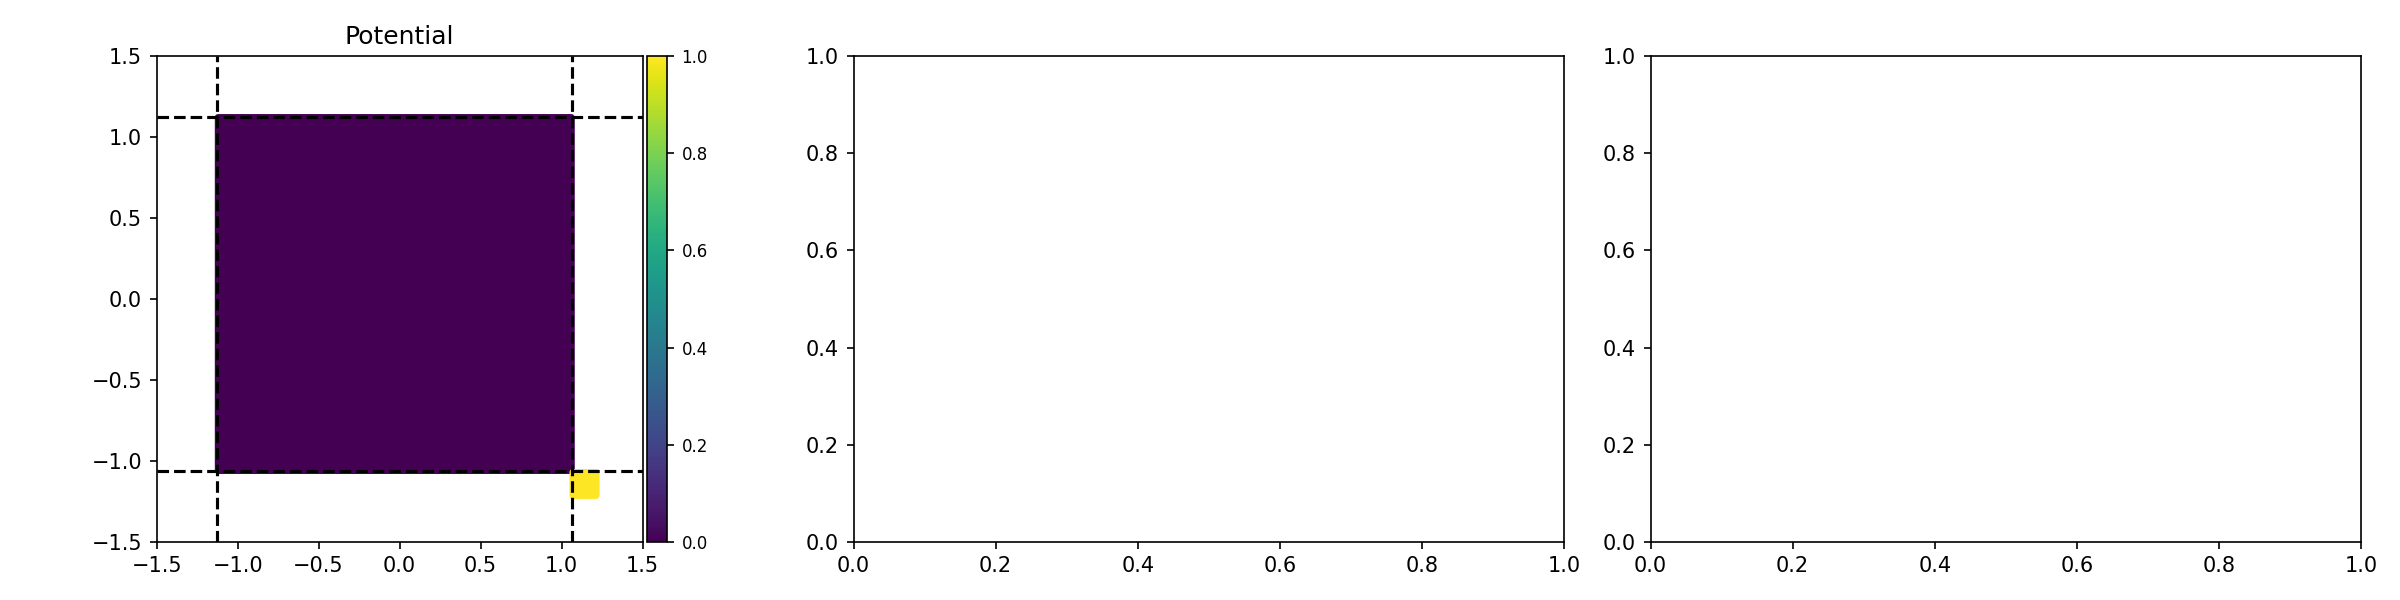

In [77]:
print(ghostIndices[0])

def scatter(fig, axis, ptcls, data):
    sc = axis.scatter(ptcls[:,0], ptcls[:,1], s = 4, c = data)
    axis.axis('equal')
    axis.set_xlim(-1.5, 1.5)
    axis.set_ylim(-1.5, 1.5)
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    
fig, axis = plt.subplots(1, 3, figsize=(16,4), sharex = False, sharey = False, squeeze = False)

indices = torch.hstack((torch.ones_like(x)[:,0] * 0, torch.ones_like(y)[:,0] * 1))
positions = torch.vstack((x, y))

# for i in range(len(ghostIndices)):    
#     scatter(fig, axis[0,0], particles[ghostIndices[i]] + ghostOffsets[i], torch.ones_like(ghostIndices[i]) * i)
axis[0,0].set_title('Potential')
scatter(fig, axis[0,0], positions, indices)
axis[0,0].axvline(sphSimulation.config['domain']['min'][0], ls = '--', c = 'black')
axis[0,0].axhline(sphSimulation.config['domain']['min'][1], ls = '--', c = 'black')
axis[0,0].axvline(sphSimulation.config['domain']['max'][0], ls = '--', c = 'black')
axis[0,0].axhline(sphSimulation.config['domain']['max'][1], ls = '--', c = 'black')
# scatter(fig, axis[0,2], ptcls, np.linalg.norm(vel, axis = 1))
    
fig.tight_layout()

In [72]:
# print(ghostIndices[0])

# def scatter(fig, axis, ptcls, data):
#     sc = axis.scatter(ptcls[:,0], ptcls[:,1], s = 4, c = data)
#     axis.axis('equal')
#     axis.set_xlim(-1.5, 1.5)
#     axis.set_ylim(-1.5, 1.5)
#     ax1_divider = make_axes_locatable(axis)
#     cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
#     cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
#     cbar.ax.tick_params(labelsize=8) 
    
# fig, axis = plt.subplots(1, 3, figsize=(16,4), sharex = False, sharey = False, squeeze = False)
# indices = torch.cat([torch.ones_like(g) * i + 1 for i,g in enumerate(ghostIndices)])
# positions = torch.cat([particles[g] + offset for g, offset in zip(ghostIndices, ghostOffsets)])

# indices = torch.hstack((torch.ones_like(particles)[:,0] * 0, indices))
# positions = torch.vstack((particles, positions))

# # for i in range(len(ghostIndices)):    
# #     scatter(fig, axis[0,0], particles[ghostIndices[i]] + ghostOffsets[i], torch.ones_like(ghostIndices[i]) * i)
# axis[0,0].set_title('Potential')
# scatter(fig, axis[0,0], positions, indices)
# axis[0,0].axvline(sphSimulation.config['domain']['min'][0], ls = '--', c = 'black')
# axis[0,0].axhline(sphSimulation.config['domain']['min'][1], ls = '--', c = 'black')
# axis[0,0].axvline(sphSimulation.config['domain']['max'][0], ls = '--', c = 'black')
# axis[0,0].axhline(sphSimulation.config['domain']['max'][1], ls = '--', c = 'black')
# # scatter(fig, axis[0,2], ptcls, np.linalg.norm(vel, axis = 1))
    
# fig.tight_layout()

In [31]:
x = ptcls
y = ptcls

torch.minimum(torch.min(torch.tensor(ptcls),dim=0)[0], torch.min(torch.tensor(ptcls),dim=0)[0])

tensor([-1.1178, -1.0572], dtype=torch.float64)

In [45]:
print(sphSimulation.config['domain']['min'])
print(dx)

[-1.0952381 -1.0952381]
0.06060606060606061


<IPython.core.display.Javascript object>


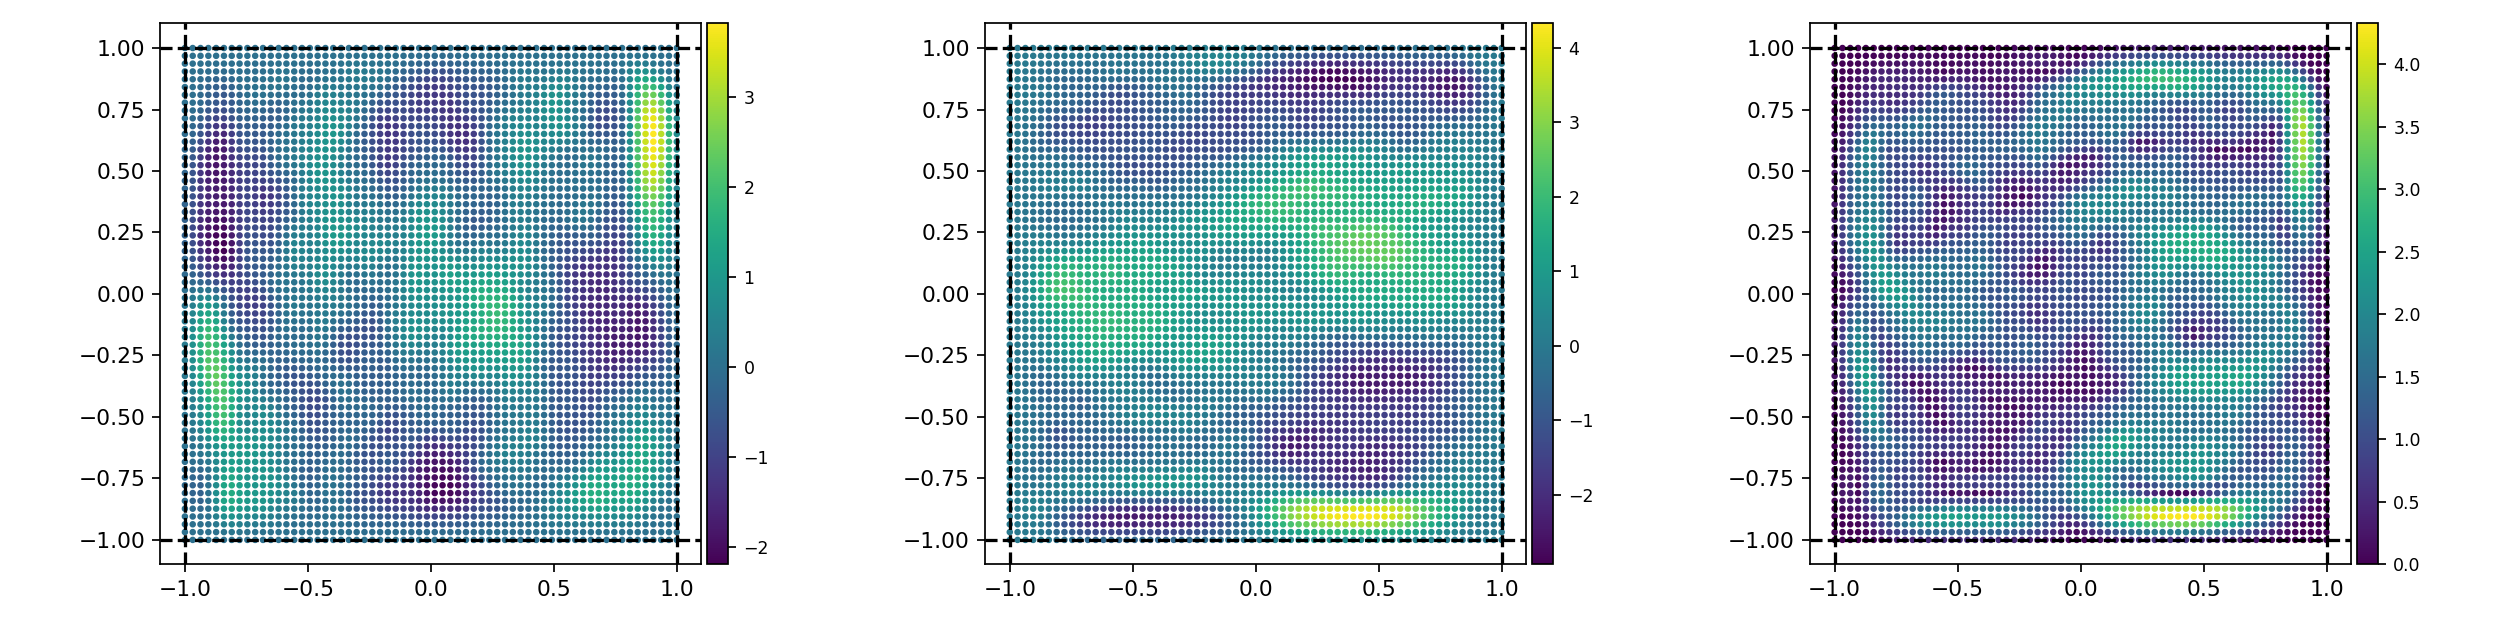

In [43]:
from src.randomParticles import genNoisyParticles, filterNoise, noisifyParticles, createPotentialField

nx = max(sphSimulation.config['generative']['nb'][0], sphSimulation.config['generative']['nb'][1])
dx = 2 / (nx + 1)
area = dx**2

ptcls  = 

xx, yy, noise = createPotentialField(n = self.config['generative']['n'], res = self.config['generative']['res'], \
                    octaves = self.config['generative']['octaves'], lacunarity = self.config['generative']['lacunarity'], persistance = self.config['generative']['persistance'], \
                        seed = self.config['generative']['seed'])
filtered = filterNoise(noise, minDomain, minCenter, boundary = self.config['generative']['boundaryWidth'], nd = np.array(self.config['generative']['nd']), n = self.config['generative']['n'], dh = 1e-2)
noiseSampler = interpolate.RegularGridInterpolator((np.linspace(-1,1,self.config['generative']['n']), np.linspace(-1,1,self.config['generative']['n'])), filtered, bounds_error = False, fill_value = None, method = 'linear')


fig, axis = plt.subplots(1, 3, figsize=(16,4), sharex = False, sharey = False, squeeze = False)

def scatter(fig, axis, ptcls, data):
    sc = axis.scatter(ptcls[:,0], ptcls[:,1], s = 4, c = data)
    axis.axis('equal')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
    cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
    cbar.ax.tick_params(labelsize=8) 
    axis.axvline(-1, ls = '--', c = 'black')
    axis.axvline(1, ls = '--', c = 'black')
    axis.axhline(-1, ls = '--', c = 'black')
    axis.axhline(1, ls = '--', c = 'black')

scatter(fig, axis[0,0], ptcls, vel[:,0])
scatter(fig, axis[0,1], ptcls, vel[:,1])
scatter(fig, axis[0,2], ptcls, np.linalg.norm(vel, axis = 1))
    
fig.tight_layout()

In [8]:
config = 'configs/periodicDomain.toml'

with open(config, 'r') as file:
    tomlConfig = file.read()
parsedConfig = tomli.loads(tomlConfig)

simulationModel = deltaSPHSimulation

sphSimulation = simulationModel(parsedConfig)
sphSimulation.initializeSimulation()

<IPython.core.display.Javascript object>


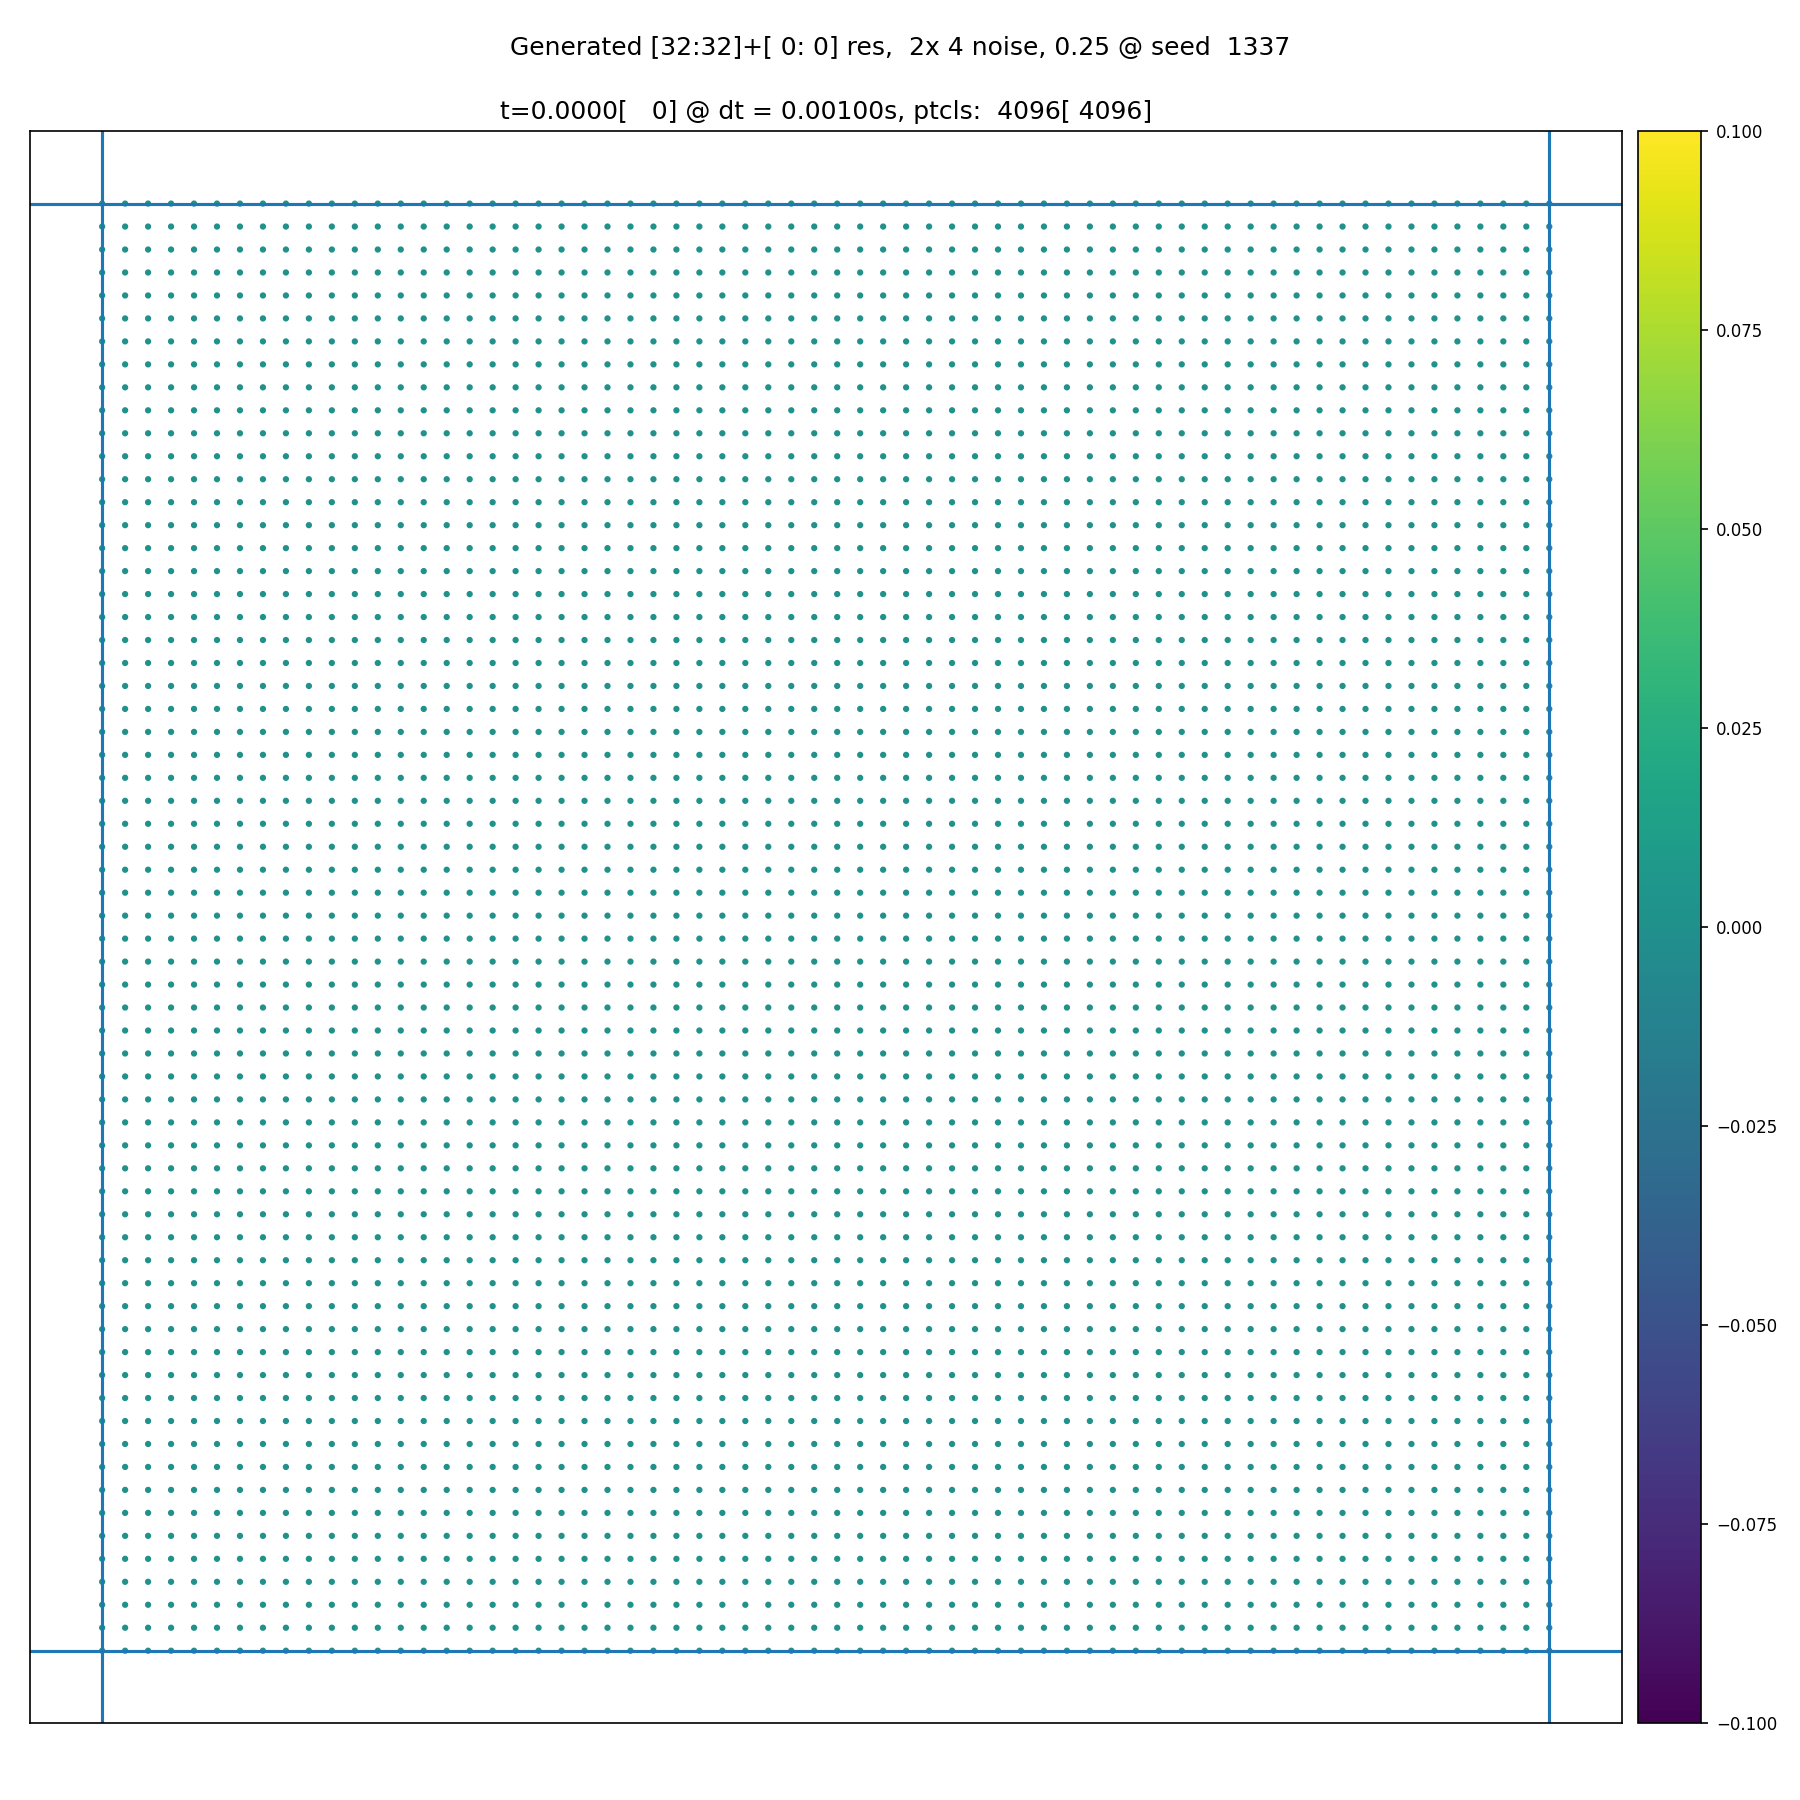

In [10]:
fig, axis = plt.subplots(1, 1, figsize=(12,12), sharex = False, sharey = False, squeeze = False)
state = sphSimulation.simulationState
axis[0,0].set_xticks([])
axis[0,0].set_yticks([])

positions = state['fluidPosition'].detach().cpu().numpy()
data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
data = state['fluidPressure'].detach().cpu().numpy()

sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 4)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

fig.suptitle('Generated [%2d:%2d]+[%2d:%2d] res, %2dx%2d noise, %3.2g @ seed %5d' % (sphSimulation.config['generative']['nb'][0],sphSimulation.config['generative']['nb'][1],sphSimulation.config['generative']['nd'][0],sphSimulation.config['generative']['nd'][1], sphSimulation.config['generative']['res'], sphSimulation.config['generative']['octaves'], sphSimulation.config['generative']['persistance'], sphSimulation.config['generative']['seed']))
axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))

axis[0,0].set_xlim(-1.1,1.1)
axis[0,0].set_ylim(-1.1,1.1)
axis[0,0].axvline(-1)
axis[0,0].axvline(1)
axis[0,0].axhline(-1)
axis[0,0].axhline(1)


fig.tight_layout()



In [20]:
sphSimulation.simulationState['fluidNeighbors'], sphSimulation.simulationState['fluidDistances'], sphSimulation.simulationState['fluidRadialDistances'] = sphSimulation.neighborSearch.search(sphSimulation.simulationState, sphSimulation)
sphSimulation.boundaryModule.boundaryFilterNeighborhoods(sphSimulation.simulationState, sphSimulation)
sphSimulation.boundaryModule.boundaryNeighborhoodSearch(sphSimulation.simulationState, sphSimulation)

sphSimulation.sphDensity.evaluate(sphSimulation.simulationState, sphSimulation)    
sphSimulation.boundaryModule.evalBoundaryDensity(sphSimulation.simulationState, sphSimulation) 
sphSimulation.simulationState['fluidAcceleration'] = torch.zeros_like(sphSimulation.simulationState['fluidVelocity'])   
sphSimulation.gravityModule.evaluate(sphSimulation.simulationState, sphSimulation)
sphSimulation.simulationState['densityIterations'] = sphSimulation.DFSPH.incompressibleSolver(sphSimulation.simulationState, sphSimulation)
sphSimulation.simulationState['fluidAcceleration'] += sphSimulation.simulationState['fluidPredAccel']
sphSimulation.velocityDiffusionModule.evaluate(sphSimulation.simulationState, sphSimulation)    

fig, axis = plt.subplots(1, 1, figsize=(12,12), sharex = False, sharey = False, squeeze = False)
state = sphSimulation.simulationState
axis[0,0].set_xticks([])
axis[0,0].set_yticks([])

positions = state['fluidPosition'].detach().cpu().numpy()
data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
data = state['fluidDensity'].detach().cpu().numpy()

sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 4)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

fig.suptitle('Generated [%2d:%2d]+[%2d:%2d] res, %2dx%2d noise, %3.2g @ seed %5d' % (sphSimulation.config['generative']['nb'][0],sphSimulation.config['generative']['nb'][1],sphSimulation.config['generative']['nd'][0],sphSimulation.config['generative']['nd'][1], sphSimulation.config['generative']['res'], sphSimulation.config['generative']['octaves'], sphSimulation.config['generative']['persistance'], sphSimulation.config['generative']['seed']))
axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))

axis[0,0].set_xlim(-1,1)
axis[0,0].set_ylim(-1,1)

fig.tight_layout()


AttributeError: 'solidBoundaryModule' object has no attribute 'boundaryToFluidNeighbors'

In [171]:
# print(sphSimulation.config['fluid'])

In [172]:
# timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
# path = './outputCollision/%s - %s/' % (config.split('/')[-1].split('.')[0], timestamp)
# if not os.path.exists(path):
#     os.makedirs(path)

In [174]:
timesteps = 128
# timesteps = 2424
for i in tqdm(range(timesteps)):
    sphSimulation.integrate()
#     break
#     sphSimulation.timestep()
    if i  % 1 == 0 or i == timesteps - 1:
#     if True:
        state = sphSimulation.simulationState
        positions = state['fluidPosition'].detach().cpu().numpy()

#         positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
        
        data = state['fluidDensity'].detach().cpu().numpy()
#         data2 = sphSimulation.boundaryModule.boundaryDensity.detach().cpu().numpy() * 0
        
#         data2 = torch.linalg.norm(sphSimulation.boundaryModule.boundaryVelocity, dim=1).detach().cpu().numpy()
        data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()
#         data = torch.linalg.norm(state['fluidUpdate'], dim=1).detach().cpu().numpy()
        
#         data = state['fluidPressure'].detach().cpu().numpy()
#         data = sphSimulation.deltaSPH.pressure.detach().cpu().numpy()
#         data2 = sphSimulation.boundaryModule.boundaryPressure.detach().cpu().numpy()

#         positions = np.vstack((positions, positions2))
#         data = np.hstack((data, data2))

        cbar.mappable.set_clim(vmin=np.min(data), vmax=np.max(data))
        sc.set_offsets(positions)
        sc.set_array(data)


        axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
        if 'densityErrors' in state and not 'divergenceErrors' in state:
            axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
        if 'divergenceErrors' in state and not 'densityErrors' in state:
            axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
        if 'densityErrors' in state and 'divergenceErrors' in state:
            axis[0,0].set_title('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

        
        fig.canvas.draw()
        fig.canvas.flush_events()
        
#         imagePath = path + '%05d.png' % state['timestep']
#         plt.savefig(imagePath)

  0%|          | 0/128 [00:00<?, ?it/s]

In [151]:
from src.modules.densityDiffusion import computeNormalizationMatrix
from src.kernels import kernel, spikyGrad, kernelGradient
simulationState = sphSimulation.simulationState
normalizationMatrix = computeNormalizationMatrix(simulationState['fluidNeighbors'][0], simulationState['fluidNeighbors'][1], \
                                                                                                  simulationState['fluidPosition'], simulationState['fluidPosition'], simulationState['fluidVolume'], simulationState['fluidVolume'],\
                                                                                                  simulationState['fluidDistances'], simulationState['fluidRadialDistances'],\
                                                                                                  sphSimulation.densityDiffusionModule.support, simulationState['fluidDensity'].shape[0], sphSimulation.densityDiffusionModule.eps)     
normalizationMatrix += sphSimulation.boundaryModule.computeNormalizationMatrices(simulationState, sphSimulation)
ni = simulationState['fluidNeighbors'][0]

In [171]:
def gj_solve(m=[1., 0.], n=3, nb=1, result=[0.0, 0.0]):
    r"""A gauss-jordan method to solve an augmented matrix.
    The routine is given the augmented matrix, the number of rows/cols in the
    original matrix and the number of added columns. The result is stored in
    the result array passed.
    Parameters
    ----------
    m : list: a flattened list representing the augmented matrix [A|b].
    n : int: number of columns/rows used from A in augmented_matrix.
    nb: int: number of columns added to A.
    result: list: with size n*nb
    References
    ----------
    https://ricardianambivalence.com/2012/10/20/pure-python-gauss-jordan
    -solve-ax-b-invert-a/
    """

    i, j, eqns, colrange, augCol, col, row, bigrow, nt = 0,0,0,0,0,0,0,0,0
    eqns = n
    colrange = n
    augCol = n + nb
    nt = n + nb

    for col in range(colrange):
        bigrow = col
        for row in range(col + 1, colrange):
            if abs(m[nt*row + col]) > abs(m[nt*bigrow + col]):
                bigrow = row
                temp = m[nt*row + col]
                m[nt*row + col] = m[nt*bigrow + col]
                m[nt*bigrow + col] = temp
    print(m.reshape(4,3))
    rr, rrcol, rb, rbr, kup, kupr, kleft, kleftr = 0,0,0,0,0,0,0,0
    for rrcol in range(0, colrange):
        for rr in range(rrcol + 1, eqns):
            dnr = float(m[nt*rrcol + rrcol])
            if abs(dnr) < 1e-12:
                return 1.0
            cc = -float(m[nt*rr + rrcol]) / dnr
            for j in range(augCol):
                m[nt*rr + j] = m[nt*rr + j] + cc * m[nt*rrcol + j]
    print(m.reshape(4,3))

    backCol, backColr = 0,0
    tol = 1.0e-12
    for rbr in range(eqns):
        rb = eqns - rbr - 1
        if (m[nt*rb + rb] == 0):
            if abs(m[nt*rb + augCol - 1]) > tol:
                # Error, singular matrix.
                return 1.0
        else:
            for backColr in range(rb, augCol):
                backCol = rb + augCol - backColr - 1
                m[nt*rb + backCol] = m[nt*rb + backCol] / m[nt*rb + rb]
            if not (rb == 0):
                for kupr in range(rb):
                    kup = rb - kupr - 1
                    for kleftr in range(rb, augCol):
                        kleft = rb + augCol - kleftr - 1
                        kk = -m[nt*kup + rb] / m[nt*rb + rb]
                        m[nt*kup + kleft] = (m[nt*kup + kleft] +
                                             kk * m[nt*rb + kleft])
    print(m.reshape(4,3))

    for i in range(n):
        for j in range(nb):
            result[nb*i + j] = m[nt*i + n + j]

    return 0.0

In [169]:
normalizationMatrix.shape
expanded = torch.zeros((normalizationMatrix.shape[0],3,3))
expanded[:,:2,:2] = normalizationMatrix
n = 2
nt = n + 1
expanded = expanded.reshape(normalizationMatrix.shape[0],9)[ni,:]
print(expanded.shape)
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)


temp = torch.zeros((ni.shape[0], 12))
res  = torch.zeros((ni.shape[0], 3))
for i in range(n):
    for j in range(n):
        temp[:,nt * i + j] = expanded[:,3 * i + j]
#         print(expanded[:,3 * i + j].shape)
    temp[:, nt*i + n] = gradW[:,i]
print(temp.reshape(ni.shape[0],4,3))
print(normalizationMatrix[ni])

torch.Size([286984, 9])
tensor([[[ 2.0370e+00, -1.1060e-02, -0.0000e+00],
         [-1.1061e-02,  2.0291e+00, -0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 2.0370e+00, -1.1060e-02,  1.3129e+04],
         [-1.1061e-02,  2.0291e+00, -4.4629e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 2.0370e+00, -1.1060e-02,  6.0596e+03],
         [-1.1061e-02,  2.0291e+00,  2.3369e+02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        ...,

        [[ 8.5401e-01,  1.2634e-01, -1.9500e-03],
         [ 1.2634e-01,  1.1822e+00, -1.5179e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 8.5401e-01,  1.2634e-01, -2.3994e+00],
         [ 1.2634e-01,  1.1822e+00, -1.7218e+01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
    

In [99]:
batch_gj_solve(temp, n, 1, res)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [172]:
normalizationMatrix.shape
expanded = torch.zeros((normalizationMatrix.shape[0],3,3))
expanded[:,:2,:2] = normalizationMatrix
n = 2
nt = n + 1
expanded = expanded.reshape(normalizationMatrix.shape[0],9)[ni,:]
print(expanded.shape)
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)


temp = torch.zeros((ni.shape[0], 12))
res  = torch.zeros((ni.shape[0], 3))
for i in range(n):
    for j in range(n):
        temp[:,nt * i + j] = expanded[:,3 * i + j]
#         print(expanded[:,3 * i + j].shape)
    temp[:, nt*i + n] = gradW[:,i]
# print(temp.reshape(ni.shape[0],4,3))
# print(normalizationMatrix[ni])

gj_solve(temp[1], n, 1, res[1])
print(temp[1].reshape(4,3))
print(res[1])

torch.Size([286984, 9])
tensor([[ 2.0370e+00, -1.1060e-02,  1.3129e+04],
        [-1.1061e-02,  2.0291e+00, -4.4629e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]])
tensor([[ 2.0370e+00, -1.1060e-02,  1.3129e+04],
        [ 0.0000e+00,  2.0291e+00,  2.6662e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00]])
tensor([[1.0000e+00, 0.0000e+00, 6.4455e+03],
        [0.0000e+00, 1.0000e+00, 1.3140e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([[1.0000e+00, 0.0000e+00, 6.4455e+03],
        [0.0000e+00, 1.0000e+00, 1.3140e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([6445.4531,   13.1399,    0.0000])


In [213]:
normalizationMatrix.device

device(type='cuda', index=0)

In [253]:
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)    
normalizedGradients = invertNormalizationMatrix_GJ(normalizationMatrix, gradW, ni)

In [254]:
gradW = kernelGradient(simulationState['fluidRadialDistances'], simulationState['fluidDistances'], sphSimulation.densityDiffusionModule.support)    
normalizedGradients = invertNormalizationMatrix_PINV(normalizationMatrix, gradW, ni)

In [256]:
dwij_mag = torch.linalg.norm(gradW, axis = 1, ord = 1)
norm_mag = torch.linalg.norm(normalizedGradients, axis = 1, ord = 1)

eps = 1e-4 * sphSimulation.densityDiffusionModule.support
tol = 0.1
change = abs(norm_mag - dwij_mag) / (dwij_mag + eps)
normalizedGradients = torch.where((change < tol)[:,None], normalizedGradients, gradW)

# print(change)

In [192]:
print(m[1].reshape(4,3))
print(res[1])

tensor([[1.0000e+00, 0.0000e+00, 6.4455e+03],
        [0.0000e+00, 1.0000e+00, 1.3140e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([6445.4531,   13.1399,    0.0000])


In [155]:
print(temp[1].reshape(4,3))
print(res[1])

tensor([[1.0000e+00, 0.0000e+00, 6.4455e+03],
        [0.0000e+00, 1.0000e+00, 1.3140e+01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([6445.4531,   13.1399,    0.0000])


In [93]:
pinv = torch.linalg.pinv(normalizationMatrix[0])
print(normalizationMatrix[0])
print(pinv)
print(pinv * normalizationMatrix[0])
print(gradW[1])
print(torch.mv(pinv, gradW[1]))


tensor([[ 2.0370, -0.0111],
        [-0.0111,  2.0291]], device='cuda:0')
tensor([[0.4909, 0.0027],
        [0.0027, 0.4928]], device='cuda:0')
tensor([[ 1.0000e+00, -2.9597e-05],
        [-2.9599e-05,  1.0000e+00]], device='cuda:0')
tensor([13129.4355,   -44.6293], device='cuda:0')
tensor([6445.4526,   13.1392], device='cuda:0')


In [23]:
# debugPrint(sphSimulation.config['particle']['support'])
# debugPrint(sphSimulation.simulationState['fluidSupport'])

In [151]:
sphSimulation.outFile.close()
# debugPrint(sphSimulation.outFile.keys())

In [11]:
# fig, axis = sphSimulation.createPlot(plotScale = 2, plotSolids = False, plotDomain = False)
# state = sphSimulation.simulationState

# positions = state['fluidPosition'].detach().cpu().numpy()
# data = state['fluidDensity'].detach().cpu().numpy()

# positions2 = sphSimulation.boundaryModule.boundaryPositions.detach().cpu().numpy()
# data2 = sphSimulation.boundaryModule.boundaryPressure.detach().cpu().numpy()

# # data2 = torch.linalg.norm(sphSimulation.boundaryModule.boundaryVelocity, dim=1).detach().cpu().numpy()
# # data = torch.linalg.norm(state['fluidVelocity'], dim=1).detach().cpu().numpy()

# # positions = np.vstack((positions, positions2))
# # data = np.hstack((data, data2))

# # data = sphSimulation.DFSPH.fluidAlpha
# data = state['fluidPressure']

# # positions = positions2
# # data = data2

# sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = data, s = 2)
# axis[0,0].axis('equal')

# ax1_divider = make_axes_locatable(axis[0,0])
# cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
# cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
# cbar.ax.tick_params(labelsize=8) 

# # quiverData = state['fluidUpdate'].detach().cpu().numpy()
# # qv = axis[0,0].quiver(positions[:,0], positions[:,1], quiverData[:,0], quiverData[:,1], \
# #                       scale_units='xy', scale = 0.1) #scale = 2/ sphSimulation.config['particle']['support'], alpha=0.5)

# fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles']))
# if 'densityErrors' in state and not 'divergenceErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'], state['numParticles'],state['realParticles'],len(state['densityErrors'])))
# if 'divergenceErrors' in state and not 'densityErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['divergenceErrors'])))
# if 'densityErrors' in state and 'divergenceErrors' in state:
#     fig.suptitle('t=%2.4f[%4d] @ dt = %1.5fs, ptcls: %5d[%5d], dfsph: [%3d, %3d]'%(state['time'], state['timestep'], state['dt'],state['numParticles'],state['realParticles'],len(state['densityErrors']),len(state['divergenceErrors'])))

# fig.tight_layout()



In [104]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],with_stack=False, profile_memory=True) as prof:    
    for i in range(1):
        with record_function("full Timestep"): 
            sphSimulation.integrate()
        
# print(prof.key_averages().table(sort_by='self_cpu_time_total'))
print(prof.key_averages().table(sort_by='cpu_time_total'))

prof.export_chrome_trace("traceGPU.json")

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          full Timestep         0.66%       2.732ms        98.52%     404.890ms     404.890ms          -4 b        -284 b       1.51 Mb     -76.14 Mb             1  
                                  9 - density diffusion         0.06%     237.000us        35.73%     146.846ms      36.712ms         -16 b        -548 b     855.50 Kb           0 b             4  
         